Notebook created on 25/06/2025 to investigate EUl small domain MAR3.14-MPI sim

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

veg_mar = ['No Veg.', # 0
           'Crops Low', # 1
           'Crops Medium', # 2
           'Crops High', # 3
           'Grass low', # 4
           'Grass Medium', # 5
           'Grass High', # 6
           'Broadleaf Low', # 7
           'Broadleaf Medium', # 8
           'Broadleaf High', # 9
           'Needle Low', # 10
           'Needle Medium', # 11
           'Needle High', # 12
           'City'] # 13

In [3]:
ds_small = xr.open_dataset('/bettik/castelli/MARout/EUh/h01/2015/ICE.h01.2015.01.01-31.nc')[["LON","LAT","SH","FRV","VEG"]]
#ds_smallish = xr.open_dataset('/bettik/castelli/MARout/EUm/m01/2014/ICE.m01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]
ds_smallish = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/MARgrid_EUm.nc')
ds_big = xr.open_dataset('/bettik/castelli/MARout/EUn/n01/2014/ICE.n01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

alps_month = np.repeat(alps[np.newaxis,:,:],12,axis=0)

lon_smallish = np.array(ds_smallish.LON)
lat_smallish = np.array(ds_smallish.LAT)
H_smallish = np.array(ds_smallish.SH)
alps_smallish = detect_alps(H_smallish)
alps_smallish[lon_smallish<4.8] = False
alps_smallish[np.logical_and(lon_smallish>10,lat_smallish<45.2)] = False

In [5]:
def open_monthly_data_ave(vars,year,month,days_in_month,sim,timestep_in_hours = 2,imin = 32,imax = -30,jmin = 20,jmax = -15,whichpath='castelli',
                         ds_sect = ds_small,combine=False):
    # average of mosaics
    # example of vars : ["GF","SWU","SWD","HAcc","LWU","LWD","SHF","LHF","HA_col","MBm","MBr","MBmTop","MBrTop","MB","MBrr","SAbs_v","SAbs","CC","CU","CM","CD",
    #                    "QQz","TTz","ST","SWt"]
    if whichpath=='castelli':
        path = '/bettik/castelli/MARout/EU'
    else:
        path = '/bettik/menegozm/MARout/EU'
    letter = sim[0]
    code = sim[1:]
    path = path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'

    #ds_day = xr.open_dataset(path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),
    #                                                                                                                                                y=slice(jmin,jmax))
    if combine:
        files = []
        for i in range(len(month)):
            files.append(path+month[i]+'.01-'+days_in_month[i]+'.nc')
        ds_day = xr.open_mfdataset(files,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')[vars].isel(x=slice(imin,imax),
                                                                                                                                                y=slice(jmin,jmax))
    else:
        ds_day = xr.open_dataset(path+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),y=slice(jmin,jmax))
        
    # Melt
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*timestep_in_hours # 60*60*24 seconds in a day
    if('MBm' in vars):
        melt_MBm = ds_day.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg
        ds_day_melt = melt_MBm * Lf / t_timestep # kg.m**(-2) * J.kg**(-1) / s = J/s.m**(-2) = W.m**(-2)
        ds_day['melt'] = -ds_day_melt # minus sign because energy is LOST by surface in order to melt snow
    if('MBr' in vars):
        freez_MBr = ds_day.MBr.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBr.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MBr.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez = freez_MBr * Lf / t_timestep
        ds_day['freeze'] = ds_day_freez
    if('MBmTop' in vars):
        melt_MBm_top = ds_day.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_melt_top = melt_MBm_top * Lf / t_timestep
        ds_day['melt_top'] = -ds_day_melt_top
    if('MBrTop' in vars):
        freez_MBr_top = ds_day.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez_top = freez_MBr_top * Lf / t_timestep
        ds_day['freeze_top'] = ds_day_freez_top
    if('MB' in vars):
        average_snow = ds_day.MB.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MB.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MB.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day['MBave'] = average_snow
    if('SWD' in vars and 'SWU' in vars):
        ds_day['NSW'] = ds_day.SWD - ds_day.SWU
    if('LWD' in vars and 'LWU' in vars):
        ds_day['NLW'] = ds_day.LWD - ds_day.LWU
    if('TTz' in vars):
        ds_day['TT2'] = ds_day.TTz.sel(ztqlev=2.0)
    if('SWt' in vars):
        ds_day['SWt'] = -ds_day['SWt'] # - sign because the energy transmitted to lower layers is LOST by the surface
    if('MBrr' in vars and 'MBsf' in vars):
        ds_day['precip'] = ds_day.MBrr + ds_day.MBsf
    if('SWD' in vars and 'SWU' in vars and 'LWD' in vars and 'LWU' in vars and 'SHF' in vars and 'LHF' in vars and 'MBmTop' in vars and 'MBrTop' in vars and 'GF' in vars
       and 'HAcc' in vars and 'SWt' in vars):
        ds_day_surf_balance = ds_day.NSW + ds_day.NLW + ds_day.SHF + ds_day.LHF + ds_day.melt_top + ds_day.freeze_top + ds_day.GF + ds_day.HAcc + ds_day.SWt
        ds_day['Surf_Bal'] = ds_day_surf_balance

    return ds_day

In [6]:
def plot_comparison(list_ds,months,min,max,colormap,label_var,suptitle_var,ds_size=ds_small,N=11,rows=2):

    f, axs = pplt.subplots(proj='cyl',axwidth=2,ncols=4,nrows=rows,axheight=1.)

    for mon in range(len(list_ds)):    
        ax=axs[mon]
        m = ax.pcolormesh(ds_size.LON,ds_size.LAT,list_ds[mon],levels=np.linspace(min,max,N),cmap=colormap)
        ax.format(title=months[mon])

    f.colorbar(m,label= label_var,labelsize='large',ticklabelsize='large')
    axs.format(**multiplot_format,suptitle=suptitle_var)

In [7]:
def open_nc_monthly(scenario,first_year,last_year,ds_sect):
    inipath = '/bettik/castelli/data/MAR-MPI-ESM/v3.14/'+scenario+'/ICE.MPI_ESM_'+scenario+'.EUm.' # initial path

    for year in range(first_year,last_year):
        ds_monthly = xr.open_dataset(inipath+list_var[0]+'.'+str(year)+'.nc').resample(time='M').mean()

        for var in list_vars[1:]:
            ds_monthly[var] = xr.open_dataset(inipath+var+'.'+str(year)+'.nc').resample(time='M').mean()

    # Melt
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*24*complete # 60*60*24 seconds in a day
    if('MBm' in vars):
        melt_MBm = ds_monthly.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_monthly.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_monthly.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg
        ds_monthly_melt = melt_MBm * Lf / t_timestep # kg.m**(-2) * J.kg**(-1) / s = J/s.m**(-2) = W.m**(-2)
        ds_monthly['melt'] = -ds_monthly_melt # minus sign because energy is LOST by surface in order to melt snow
    if('MBr' in vars):
        freez_MBr = ds_day.MBr.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBr.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MBr.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez = freez_MBr * Lf / t_timestep
        ds_day['freeze'] = ds_day_freez
    if('MBmTop' in vars):
        melt_MBm_top = ds_day.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_melt_top = melt_MBm_top * Lf / t_timestep
        ds_day['melt_top'] = -ds_day_melt_top
    if('MBrTop' in vars):
        freez_MBr_top = ds_day.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez_top = freez_MBr_top * Lf / t_timestep
        ds_day['freeze_top'] = ds_day_freez_top
    if('MB' in vars):
        average_snow = ds_day.MB.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MB.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MB.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day['MBave'] = average_snow
    if('SWD' in vars and 'SWU' in vars):
        ds_day['NSW'] = ds_day.SWD - ds_day.SWU
    if('LWD' in vars and 'LWU' in vars):
        ds_day['NLW'] = ds_day.LWD - ds_day.LWU
    if('TTz' in vars):
        ds_day['TT2'] = ds_day.TTz.sel(ztqlev=2.0)
    if('SWt' in vars):
        ds_day['SWt'] = -ds_day['SWt'] # - sign because the energy transmitted to lower layers is LOST by the surface
    if('MBrr' in vars and 'MBsf' in vars):
        ds_day['precip'] = ds_day.MBrr + ds_day.MBsf
    if('SWD' in vars and 'SWU' in vars and 'LWD' in vars and 'LWU' in vars and 'SHF' in vars and 'LHF' in vars and 'MBmTop' in vars and 'MBrTop' in vars and 'GF' in vars
       and 'HAcc' in vars and 'SWt' in vars):
        ds_day_surf_balance = ds_day.NSW + ds_day.NLW + ds_day.SHF + ds_day.LHF + ds_day.melt_top + ds_day.freeze_top + ds_day.GF + ds_day.HAcc + ds_day.SWt
        ds_day['Surf_Bal'] = ds_day_surf_balance

In [8]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [9]:
def plot_monthly_2points(ds_var,x_axis,first,last,iloc1,jloc1,iloc2,jloc2,ymin,ymax,names_var,colors,titleoffig):
# ------------------------------------------------- Map ------------------------------------------------
        
    colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
    f, ax = pplt.subplots(proj='cyl', axwidth=5)
    m=ax.pcolormesh(ds_smallish.LON, ds_smallish.LAT, ds_smallish.SH, levels=17,cmap=colors_land)
    f.colorbar(m,label= 'm.a.s.l.',labelsize='large',ticklabelsize='large')

    ax.plot(ds_smallish.LON[iloc1,jloc1], ds_smallish.LAT[iloc1,jloc1],'rx',markersize=8,markeredgewidth=1.5)
    ax.plot(ds_smallish.LON[iloc2,jloc2], ds_smallish.LAT[iloc2,jloc2],'bx',markersize=8,markeredgewidth=1.5)

    ax.format(**normal_format)
    ax.format(ocean=True,oceancolor='royalblue',reso='hi')

# ------------------------------------------------- Time series plots ------------------------------------------------

    #longitude_point = round(float(lon[iloc,jloc]),2)
    #latitude_point = round(float(lat[iloc,jloc]),2)
    f, axs = pplt.subplots(axwidth=5,axheight=0.4,ncols=2,nrows=2,hratios=(1,5),ref=1,sharey=False)
    pplt.rc.update(small=10, large=12)
    
    #ds_var_ave['Surf_Bal_HA_col'] = ds_var_ave.NSW + ds_var_ave.NLW + ds_var_ave.SHF + ds_var_ave.LHF + ds_var_ave.melt + ds_var_ave.freeze + ds_var_ave.HA_col
    #ds_var['Surf_Bal_HA_colk'] = ds_var.NSWk + ds_var.NLWk + ds_var.SHFk + ds_var.LHFk + ds_var.meltk + ds_var.freezek + ds_var.HA_colk

    for i,var in enumerate(names_var):
        if(var=='Surf_Bal' or var=='Surf_Bal_HA_col' or var=='Surfbal'):
            line_width=2.5
        else:
            line_width=1
        ax=axs[2]
        ax.set_ylim([ymin,ymax])
        ax.format(ylabel='W/$m^2$')
        ax.scatter(x_axis[first:last], np.array(ds_var[var])[first:last,iloc1,jloc1], c=colors[i], s=10)
        ax.plot(x_axis[first:last], np.array(ds_var[var])[first:last,iloc1,jloc1], c=colors[i],linewidth=line_width)
        
        ax=axs[3]
        ax.set_ylim([ymin,ymax])
        ax.scatter(x_axis[first:last], np.array(ds_var[var])[first:last,iloc2,jloc2], c=colors[i], s=10)
        ax.plot(x_axis[first:last], np.array(ds_var[var])[first:last,iloc2,jloc2], c=colors[i],linewidth=line_width,label=var)


    max_MB = max(np.array(ds_var['MB'])[first:last,:,iloc1,jloc1].max(), np.array(ds_var['MB'])[:,first:last,iloc2,jloc2].max())
    ax=axs[0]
    ax.format(title='Point 1 (red)',ylabel='Snow \n(mmWe)')
    ax.set_ylim([-0.1,max_MB])
    ax.plot(x_axis[first:last], np.array(ds_var['MB'].max(axis=1))[first:last,iloc1,jloc1], c='skyblue',linewidth=line_width)

    max_MB = np.array(ds_var['MB'])[first:last,:,iloc2,jloc2].max()
    ax=axs[1]
    ax.format(title='Point 2 (blue)')
    ax.plot(x_axis[first:last], np.array(ds_var['MB'].max(axis=1))[first:last,iloc2,jloc2], c='skyblue',linewidth=line_width)

    #f.format(titlesize='20px',suptitle=f'Gridpoint (lon {longitude_point}°, lat {latitude_point}°)')
    f.legend(loc='b',prop = { "size": 10 },ncols=4)
    f.format(suptitle=titleoffig)

In [11]:
# MARv3.10
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP585'
sim = 'EUy'
sim2 = 'EUy'
data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly
year = 2015

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2015 = xr.open_dataset(ssp585_path)


ds_EUy2015['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2015["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2015["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2015["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2015["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2015["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2015["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2015["precip"] = ds_EUy2015["MBrr"] + ds_EUy2015["MBsf"]

In [8]:
scenario = 'HIST'
year = 2014

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2014 = xr.open_dataset(ssp585_path)


ds_EUy2014['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2014["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2014["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2014["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2014["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2014["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2014["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2014["precip"] = ds_EUy2014["MBrr"] + ds_EUy2014["MBsf"]

In [8]:
# MARv3.10
scenario = 'SSP585'
year = 2099

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2099 = xr.open_dataset(ssp585_path)


ds_EUy2099['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2099["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2099["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2099["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2099["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2099["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2099["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2099["precip"] = ds_EUy2099["MBrr"] + ds_EUy2099["MBsf"]

In [10]:
ds_EUy2099["MBm"] = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EUy.MBm.2099.nc').MBm

ds_sect = ds_big

ds_EUy2099.MBm.sel(sector=1.0)

<xarray.DataArray 'MBm' (time: 365, y: 126, x: 201)>
[9243990 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2099-01-01T12:00:00 ... 2099-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
    sector   float32 1.0
Attributes:
    units:          mmWE
    long_name:      Only Melting
    standard_name:  Only_Melting
    actual_range:   [ 0.      51.03728]
    cell_methods:   time: mean

In [11]:
ds_sect.FRV.sel(sector=1.0)

<xarray.DataArray 'FRV' (y: 126, x: 201)>
[25326 values with dtype=float32]
Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
    sector   float32 1.0
Attributes:
    units:          %
    long_name:      Vegetation Class Coverage
    standard_name:  Vegetation_Class_Coverage
    actual_range:   [  0. 100.]

In [ ]:
ds_EUy2099["MBm"] = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EUy.MBm.2099.nc').MBm

ds_sect = ds_big

melt_MBm = ds_EUy2099.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_EUy2099.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_EUy2099.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg

melt_MBm

### MAR-MPI : EUm, MARv3.14 100*90 domain 10km resolution

In [14]:
ds_smallish.coords['lon'] = ds_smallish.LON
ds_smallish.coords['lat'] = ds_smallish.LAT

In [15]:
# Regridding MARv3.10 onto small domain

# MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
lon_correct_xy = ds.LON # copy the incorrect lon/lat
lat_correct_xy = ds.LAT
#lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

lon_correct_xy["x"] = ("x", ds_EUy2015.x.values) # correct lon
lon_correct_xy["y"] = ("y", ds_EUy2015.y.values)

lat_correct_xy["x"] = ("x", ds_EUy2015.x.values) # correct lat
lat_correct_xy["y"] = ("y", ds_EUy2015.y.values)

ds_EUy2015.coords['lon'] = lon_correct_xy
ds_EUy2015.coords['lat'] = lat_correct_xy

ds_EUy2015_regridsmallish = u.regrid(ds_EUy2015,ds_smallish,'bilinear',globe=True,periodic=False,reuse_weights=False)

In [28]:
lon_correct_xy = ds.LON # copy the incorrect lon/lat
lat_correct_xy = ds.LAT
#lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

lon_correct_xy["x"] = ("x", ds_EUy2099.x.values) # correct lon
lon_correct_xy["y"] = ("y", ds_EUy2099.y.values)

lat_correct_xy["x"] = ("x", ds_EUy2099.x.values) # correct lat
lat_correct_xy["y"] = ("y", ds_EUy2099.y.values)

ds_EUy2099.coords['lon'] = lon_correct_xy
ds_EUy2099.coords['lat'] = lat_correct_xy

ds_EUy2099_regridsmallish = u.regrid(ds_EUy2099,ds_smallish,'bilinear',globe=True,periodic=False,reuse_weights=False)

In [29]:
ds_EUy2015_month = ds_EUy2015.groupby("time.month").mean()
ds_EUy2015_regridsmallish_month = ds_EUy2015_regridsmallish.groupby("time.month").mean()

ds_EUy2099_month = ds_EUy2099.groupby("time.month").mean()
ds_EUy2099_regridsmallish_month = ds_EUy2099_regridsmallish.groupby("time.month").mean()

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

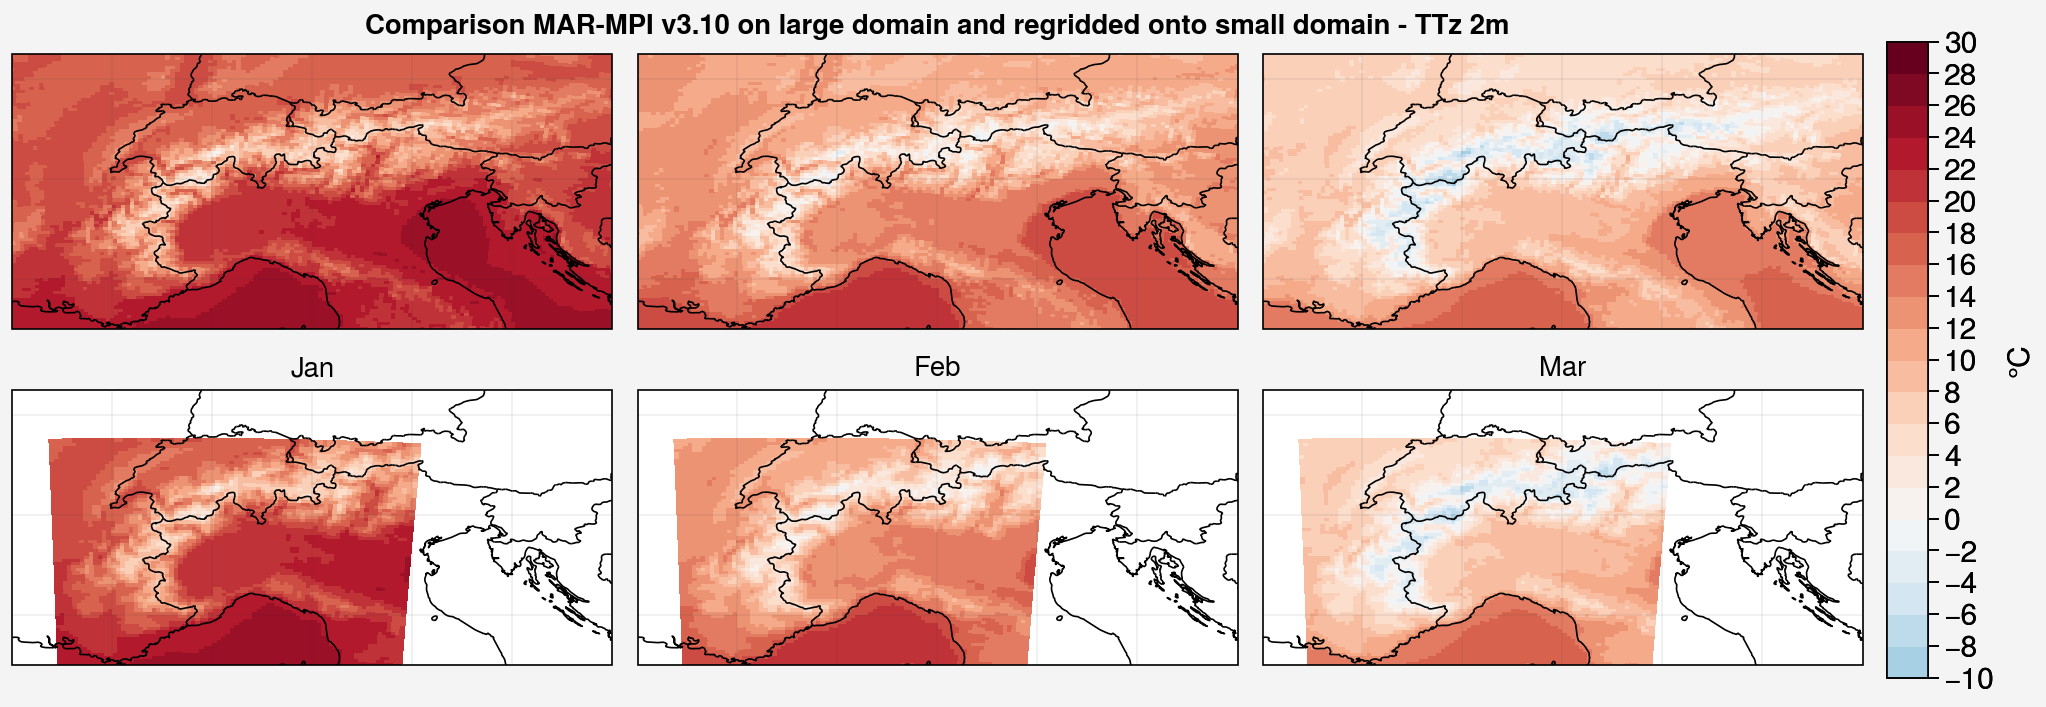

In [16]:
# Test to see if regrid worked well
# --------------------------------------------------

f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=3,nrows=2,axheight=1.5)

for mon in range(3):
    ax=axs[mon]
    m = ax.pcolormesh(ds.LON,ds.LAT,ds_EUy2015_month.TTz.isel(ztqlev=0)[mon+8],levels=np.linspace(-10,30,21),cmap='RdBu_r')
    
    ax=axs[mon+3]
    m = ax.pcolormesh(ds_small.LON,ds_small.LAT,ds_EUy2015_regridsmall_month.TTz.isel(ztqlev=0)[mon+8],levels=np.linspace(-10,30,21),cmap='RdBu_r')
    ax.format(title=months[mon])


f.colorbar(m,label= '°C',labelsize='large',ticklabelsize='large')
axs.format(**multiplot_format,suptitle='Comparison MAR-MPI v3.10 on large domain and regridded onto small domain - TTz 2m')


### m02 : 100x90 domain, no humid correction at the boundary in marmagic (still 5% in NESTOR)

In [78]:
vars_list = ["SWU","SWD","CC","QQz","TTz","ST"]
ds_EUm012015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm022015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm442099 = open_monthly_data_ave(vars=vars_list,year='2099',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m44',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

vars_list = ["MBrr","MBsf"]
ds_EUm012015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm022015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm442099_precip = open_monthly_data_ave(vars=vars_list,year='2099',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m44',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

In [20]:
ds_EUm012015 = ds_EUm012015.resample(time='D').mean()
ds_EUm012015_precip = ds_EUm012015_precip.resample(time='D').sum()
ds_EUm012015_mon = ds_EUm012015.groupby("time.month").mean()
ds_EUm012015_precip_mon = ds_EUm012015_precip.groupby("time.month").mean()

ds_EUm022015 = ds_EUm022015.resample(time='D').mean()
ds_EUm022015_precip = ds_EUm022015_precip.resample(time='D').sum()
ds_EUm022015_mon = ds_EUm022015.groupby("time.month").mean()
ds_EUm022015_precip_mon = ds_EUm022015_precip.groupby("time.month").mean()

ds_EUm442099 = ds_EUm442099.resample(time='D').mean()
ds_EUm442099_precip = ds_EUm442099_precip.resample(time='D').sum()
ds_EUm442099_mon = ds_EUm442099.groupby("time.month").mean()
ds_EUm442099_precip_mon = ds_EUm442099_precip.groupby("time.month").mean()

In [24]:
ds_EUm442099_precip_mon[var][0].values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03316944, 0.04147821, ..., 0.03955809, 0.02313049,
        0.        ],
       [0.        , 0.04174842, 0.04602172, ..., 0.08973035, 0.0451268 ,
        0.        ],
       ...,
       [0.        , 0.27668956, 0.32104272, ..., 0.2540437 , 0.16928072,
        0.        ],
       [0.        , 0.1937437 , 0.28049764, ..., 0.18459578, 0.1394151 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [30]:
ds_EUy2099_regridsmallish_month[var][0]

<xarray.DataArray 'precip' (y: 90, x: 100)>
array([[0.03747086, 0.0242358 , 0.01404483, ..., 0.8154943 , 0.8680623 ,
        0.9828074 ],
       [0.14447215, 0.12963556, 0.11401228, ..., 1.1273391 , 1.0736527 ,
        1.1410357 ],
       [0.35204515, 0.31359327, 0.28912356, ..., 1.0852237 , 1.0082983 ,
        1.0477339 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * x        (x) float32 -370.0 -360.0 -350.0 -340.0 ... 590.0 600.0 610.0 620.0
  * y        (y) float32 -440.0 -430.0 -420.0 -410.0 ... 420.0 430.0 440.0 450.0
    lat      (y, x) float32 41.96 41.96 41.97 41.97 ... 49.76 49.75 49.74 49.73
    lon      (y, x) float32 3.535 3.655 3.776 3.896 ... 16.2 16.34 16.48 16.62
    month    int64 1

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

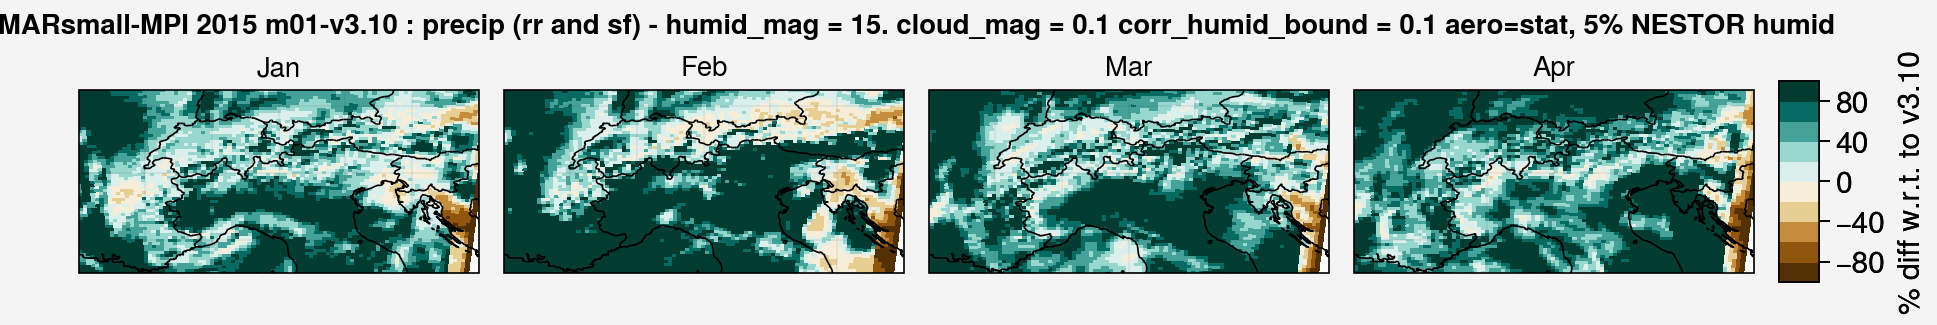

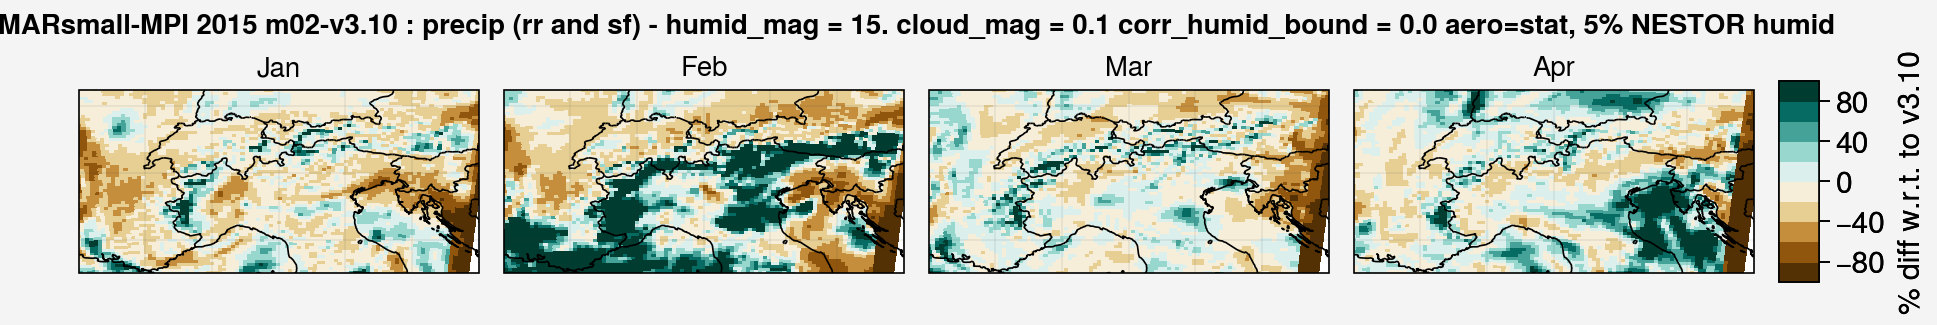

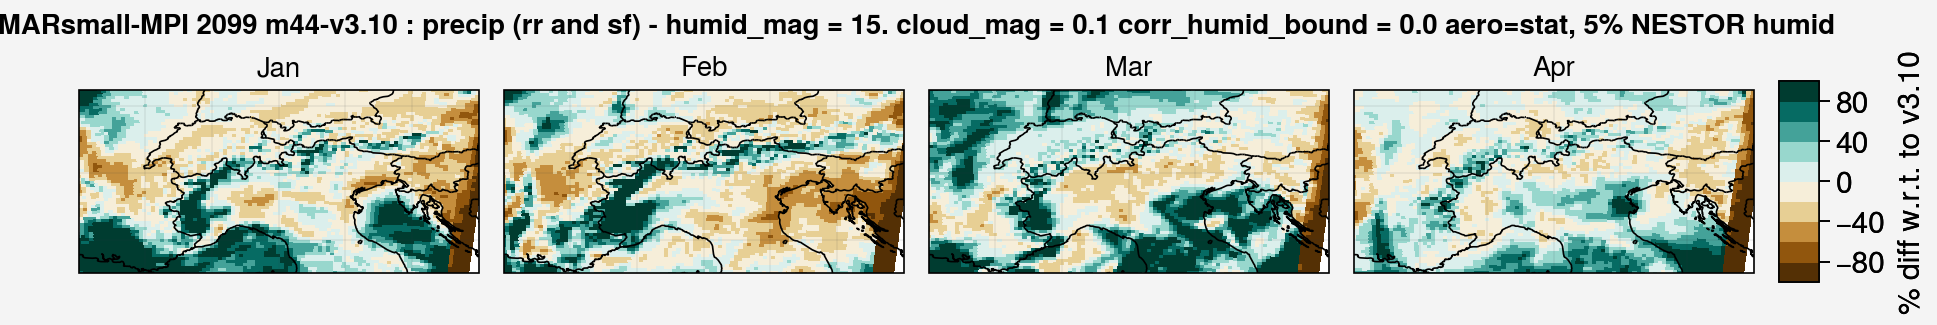

In [33]:
var = "precip"
minval = -100
maxval = 100
Nval = 11

#m01
ds_1 = ds_EUm012015_precip_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI 2015 m01-v3.10 : precip (rr and sf) - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
ds_1 = ds_EUm022015_precip_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI 2015 m02-v3.10 : precip (rr and sf) - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m44
ds_1 = ds_EUm442099_precip_mon
ds_2 = ds_EUy2099_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI 2099 m44-v3.10 : precip (rr and sf) - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

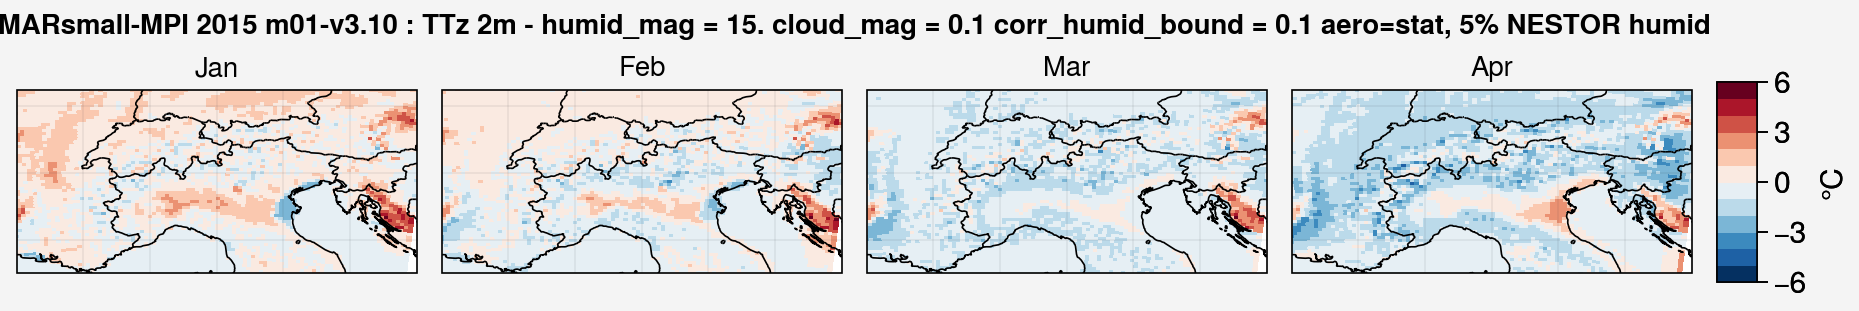

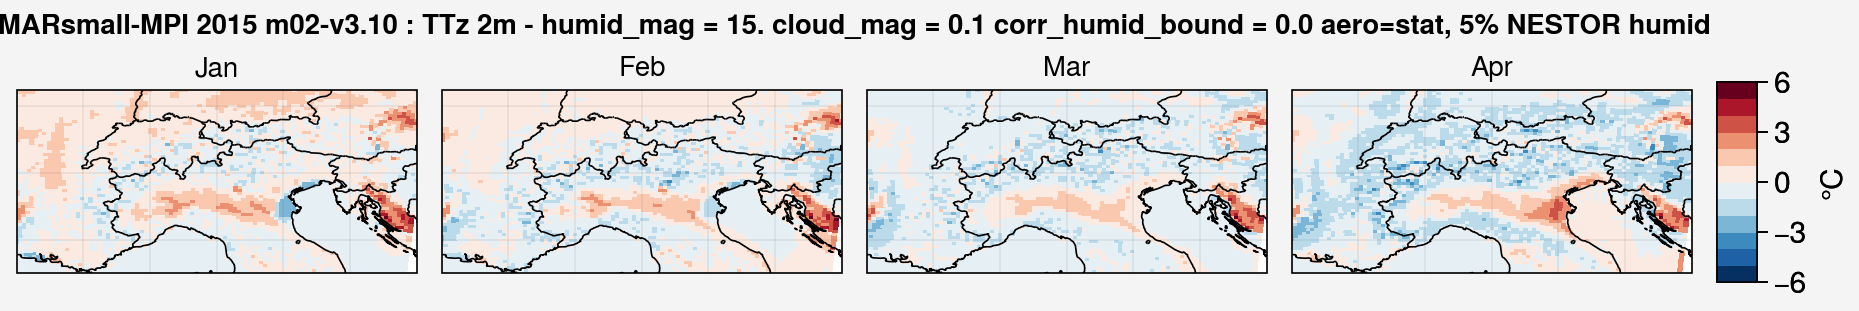

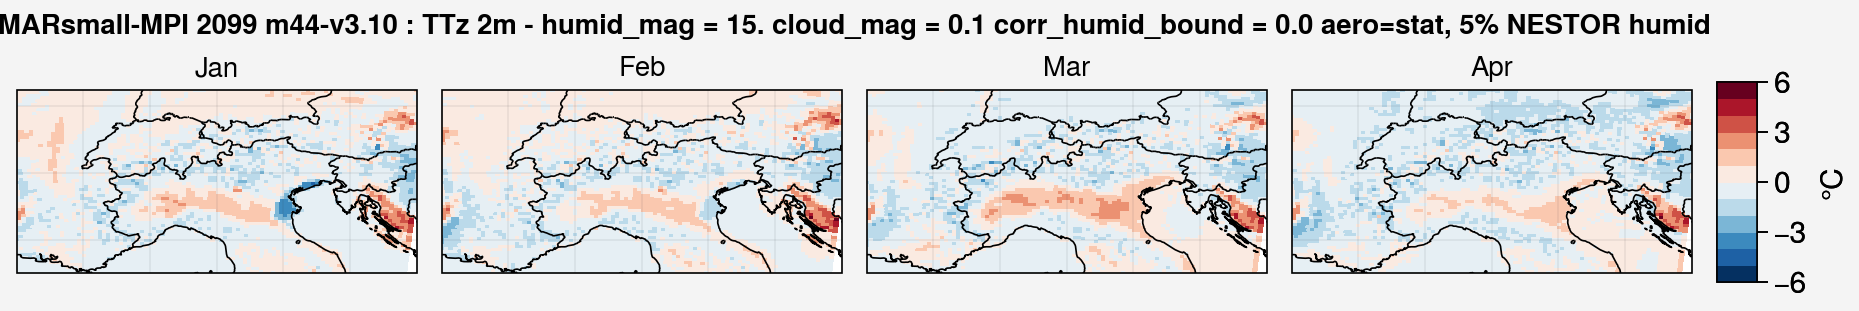

In [34]:
var = "TTz"
minval = -6
maxval = 6
Nval = 13

#m01
ds_1 = ds_EUm012015_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [ds_1[var].isel(ztqlev=0)[0] - ds_2[var].isel(ztqlev=0)[0], ds_1[var].isel(ztqlev=0)[1] - ds_2[var].isel(ztqlev=0)[1],
                           ds_1[var].isel(ztqlev=0)[2] - ds_2[var].isel(ztqlev=0)[2], ds_1[var].isel(ztqlev=0)[3] - ds_2[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI 2015 m01-v3.10 : TTz 2m - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
ds_1 = ds_EUm022015_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [ds_1[var].isel(ztqlev=0)[0] - ds_2[var].isel(ztqlev=0)[0], ds_1[var].isel(ztqlev=0)[1] - ds_2[var].isel(ztqlev=0)[1],
                           ds_1[var].isel(ztqlev=0)[2] - ds_2[var].isel(ztqlev=0)[2], ds_1[var].isel(ztqlev=0)[3] - ds_2[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI 2015 m02-v3.10 : TTz 2m - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m44
ds_1 = ds_EUm442099_mon
ds_2 = ds_EUy2099_regridsmallish_month
plot_comparison(list_ds = [ds_1[var].isel(ztqlev=0)[0] - ds_2[var].isel(ztqlev=0)[0], ds_1[var].isel(ztqlev=0)[1] - ds_2[var].isel(ztqlev=0)[1],
                           ds_1[var].isel(ztqlev=0)[2] - ds_2[var].isel(ztqlev=0)[2], ds_1[var].isel(ztqlev=0)[3] - ds_2[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI 2099 m44-v3.10 : TTz 2m - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

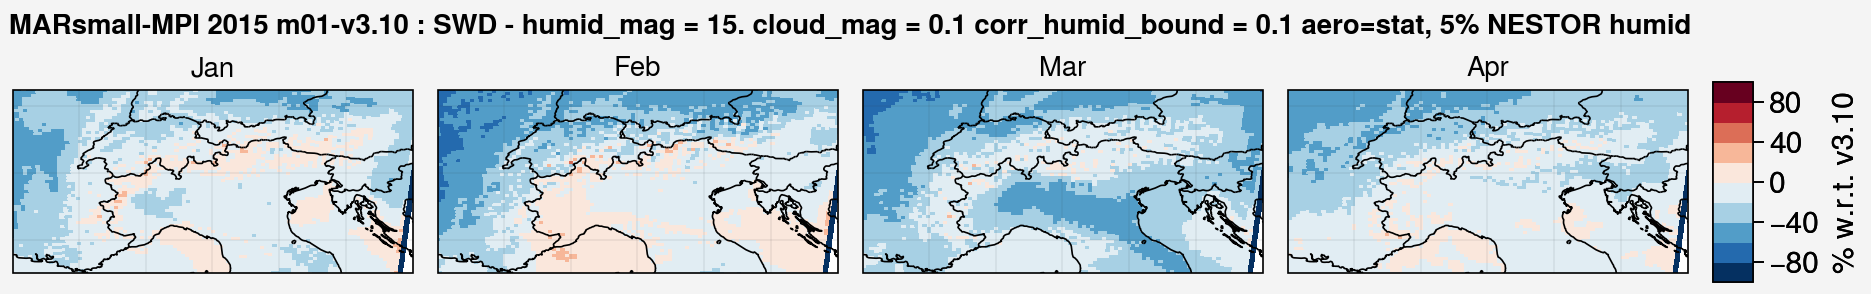

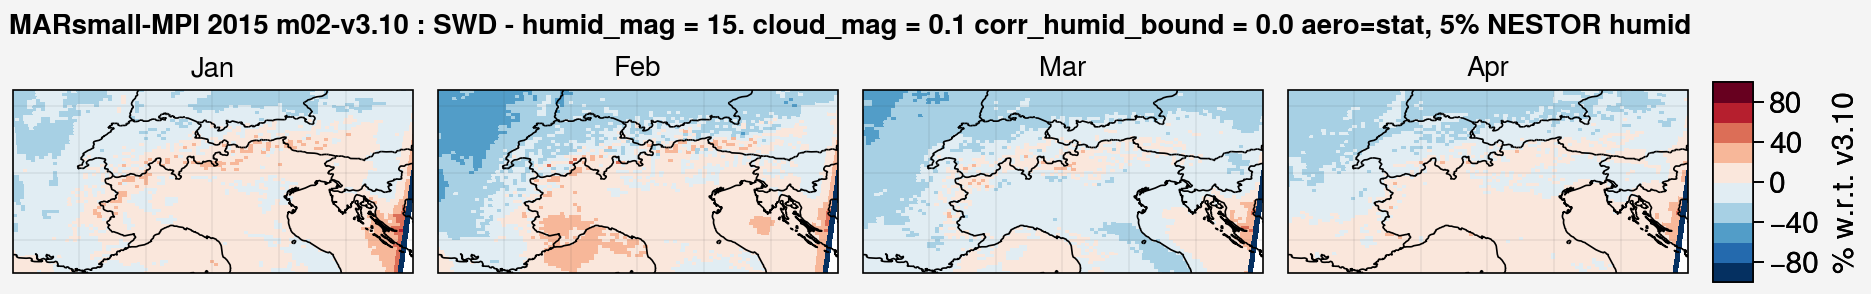

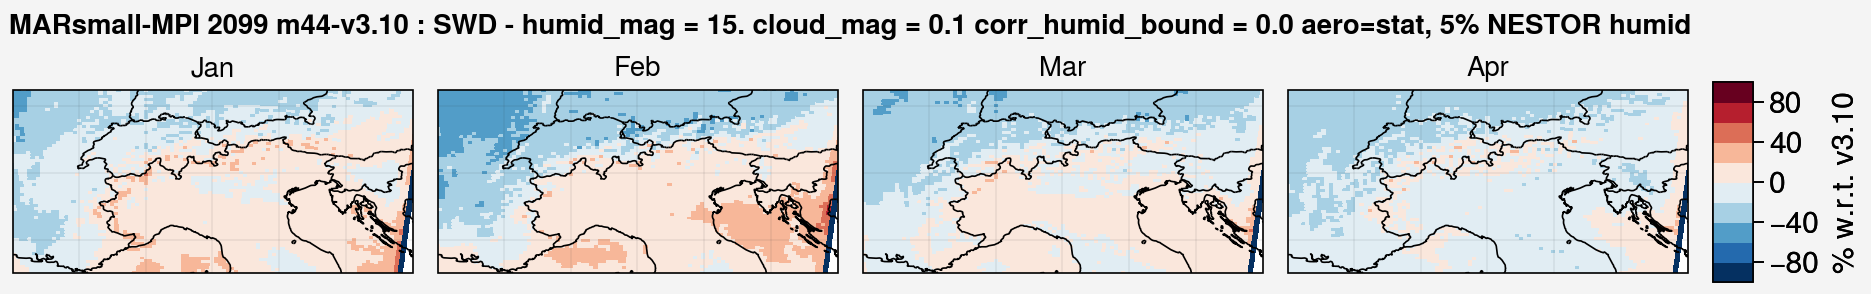

In [35]:
var = "SWD"
minval = -100
maxval = 100
Nval = 11

#m01
ds_1 = ds_EUm012015_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '% w.r.t. v3.10',
                suptitle_var = 'MARsmall-MPI 2015 m01-v3.10 : SWD - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
ds_1 = ds_EUm022015_mon
ds_2 = ds_EUy2015_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '% w.r.t. v3.10',
                suptitle_var = 'MARsmall-MPI 2015 m02-v3.10 : SWD - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m44
ds_1 = ds_EUm442099_mon
ds_2 = ds_EUy2099_regridsmallish_month
plot_comparison(list_ds = [100*(ds_1[var][0] - ds_2[var][0])/ds_2[var][0], 100*(ds_1[var][1] - ds_2[var][1])/ds_2[var][1],
                           100*(ds_1[var][2] - ds_2[var][2])/ds_2[var][2], 100*(ds_1[var][3] - ds_2[var][3])/ds_2[var][3]],
                months = ['Jan','Feb','Mar','Apr'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '% w.r.t. v3.10',
                suptitle_var = 'MARsmall-MPI 2099 m44-v3.10 : SWD - humid_mag = 15. cloud_mag = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

## Surface balance trends

### Month by month

In [ ]:
vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","TTz"]
first_yr = 2016
last_yr = 2100 # that way loop goes to 2100
mon_nr = '06'
days_nr = '30'

sim_nr = 2 # simulation number

ds_mon_yrly = open_monthly_data_ave(vars=vars_list,year=str(2015),month=mon_nr,days_in_month=days_nr,sim='m02',timestep_in_hours = 4,
                               imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()

for yr in range(first_yr,last_yr):
    if sim_nr<10:
        sim_code = '0'+str(sim_nr)
    else:
        sim_code = str(sim_nr)
    if (yr+1)%2:
        sim_nr += 1
    if mon_nr=='02':
        if yr%4==0 and yr!=2100:
            days_nr = '29'
        else:
            days_nr = '28'
    print(sim_nr,end=' ')
    ds_mon = open_monthly_data_ave(vars=vars_list,year=str(yr),month=mon_nr,days_in_month=days_nr,sim='m'+sim_code,timestep_in_hours = 4,
                                   imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()
    ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon],dim="time")

3 3 4 4 5 5 6 6 7 7 

In [70]:
ds_mon_yrly.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Jun2015-2071_surfbal.npy')

In [64]:
#ds_mon_yrly = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Jun2015-2071_surfbal.npy')
ds_mon_yrly = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Jun2015-2100_surfbal.npy')

In [65]:
ds_mon_yrly

<xarray.Dataset>
Dimensions:     (time: 86, y: 90, x: 100, sector: 3, ztqlev: 3)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * sector      (sector) float32 1.0 2.0 3.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * time        (time) datetime64[ns] 2015-06-30 2016-06-30 ... 2100-06-30
Data variables: (12/20)
    SWU         (time, y, x) float32 ...
    SWD         (time, y, x) float32 ...
    LWU         (time, y, x) float32 ...
    LWD         (time, y, x) float32 ...
    SHF         (time, y, x) float32 ...
    LHF         (time, y, x) float32 ...
    ...          ...
    freeze_top  (time, y, x) float32 ...
    MBave       (time, y, x) float32 ...
    NSW         (time, y, x) float32 ...
    NLW         (time, y, x) float32 ...
    TT2         (time, y, x) float32 ...
    Surf_Bal    (time, y, x) float32 ...
Attributes:
    title:        ICE - Exp: m02 - 20150601
    institution:  ULg (Xavier Fettweis)
    history:      libUN (2005.04.08) - Wed Jul  2 19:24:32 2025
    netcdf:       4.8.0 of May  2 2023 12:43:48 $

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_1493530/2383739220.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_1493530/2383739220.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


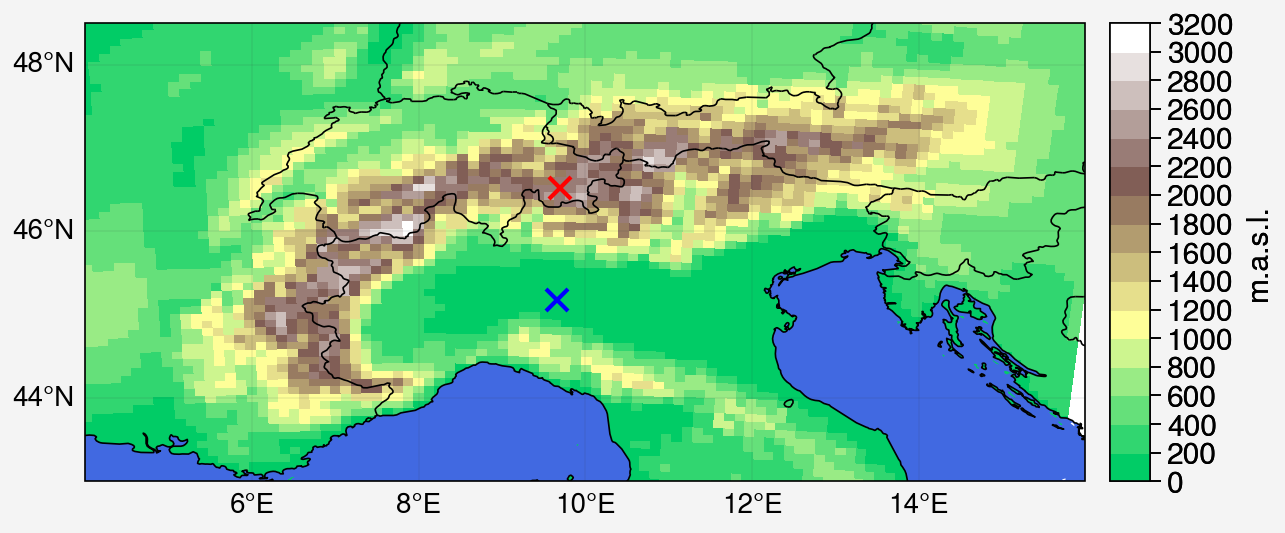

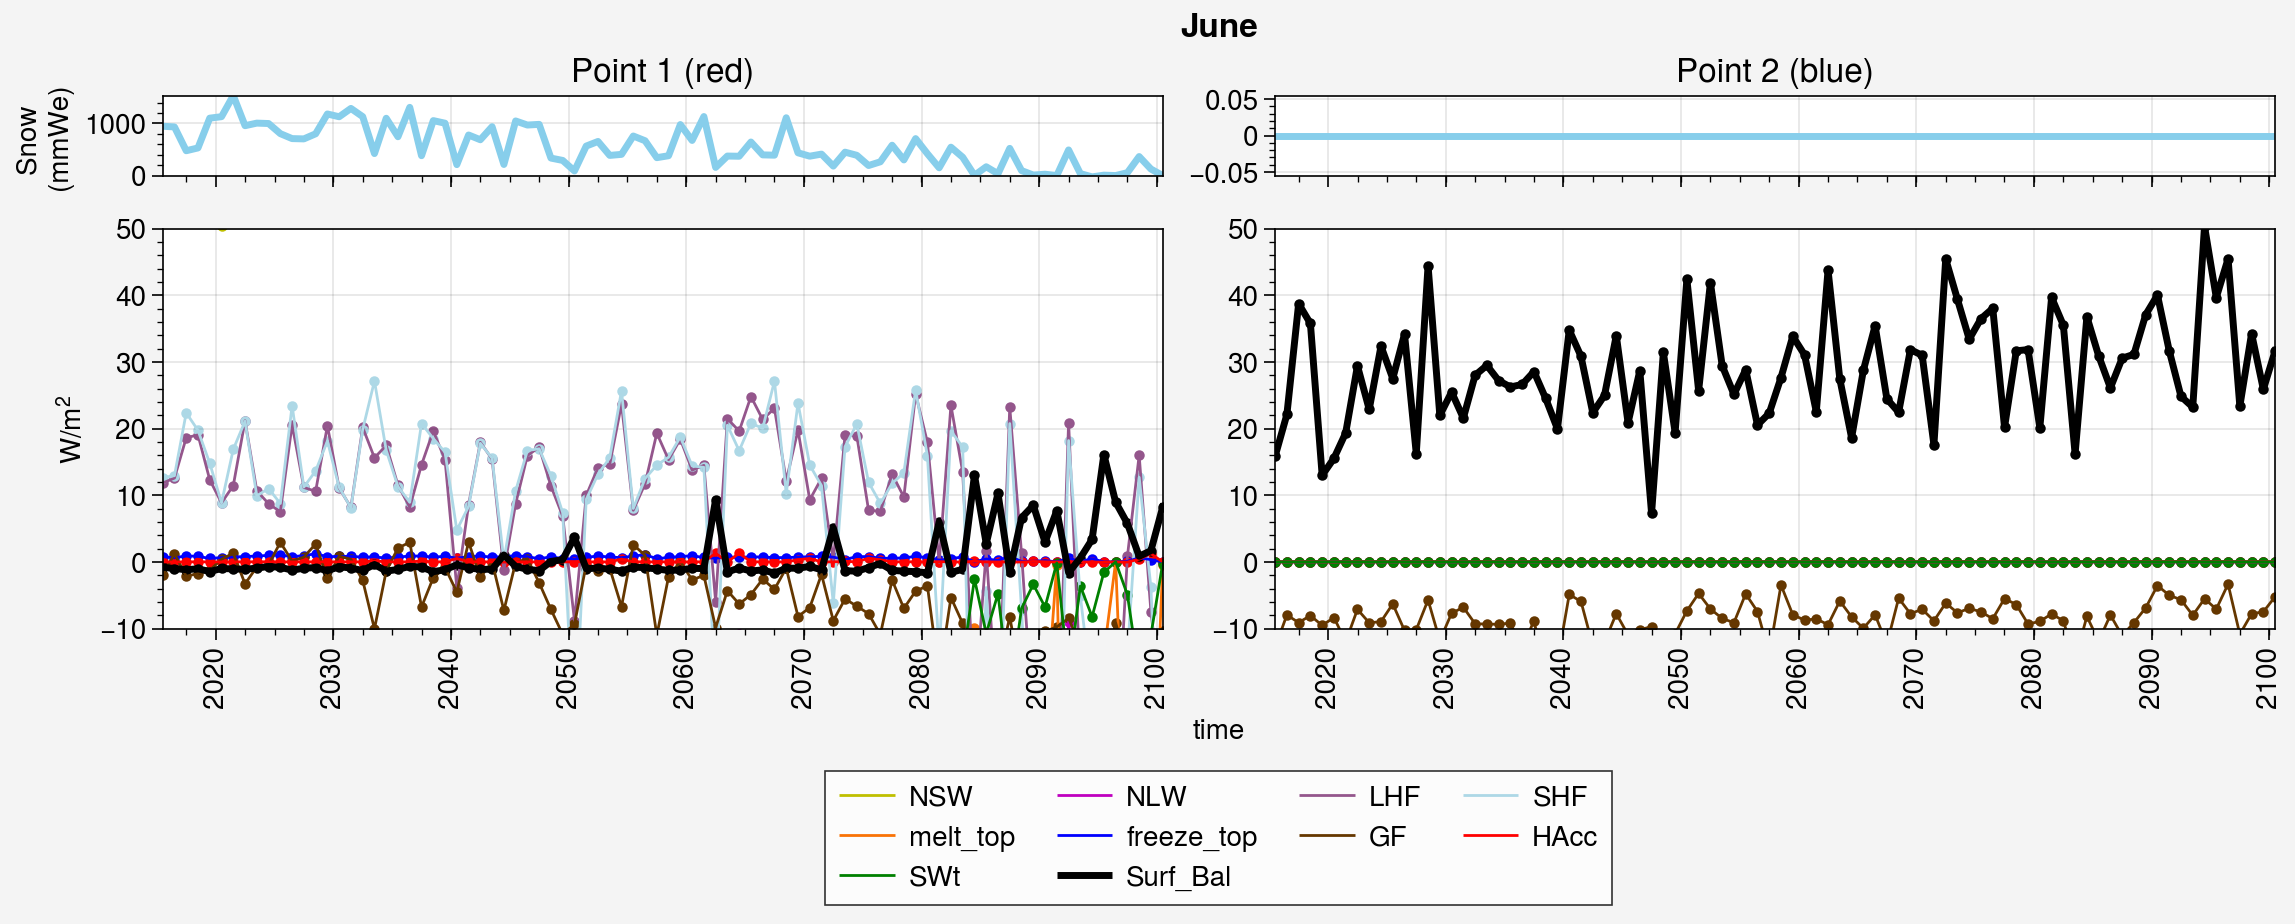

In [66]:
plot_monthly_2points(ds_mon_yrly,x_axis=ds_mon_yrly.time, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=50, ymin=-10, ymax=50,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='June')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_687756/1824204893.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_687756/1824204893.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


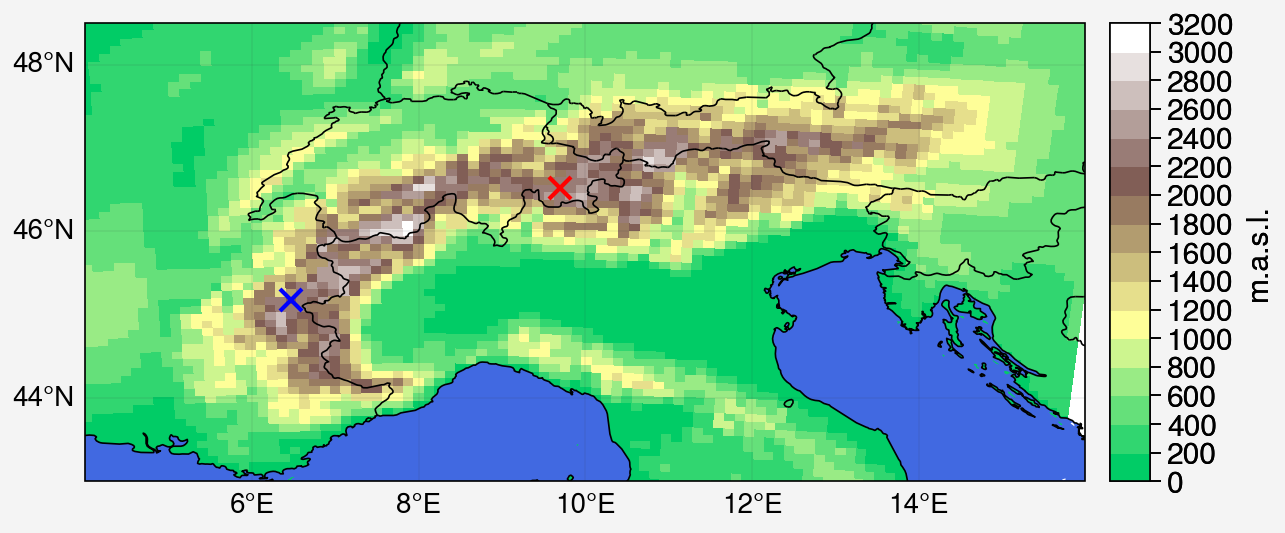

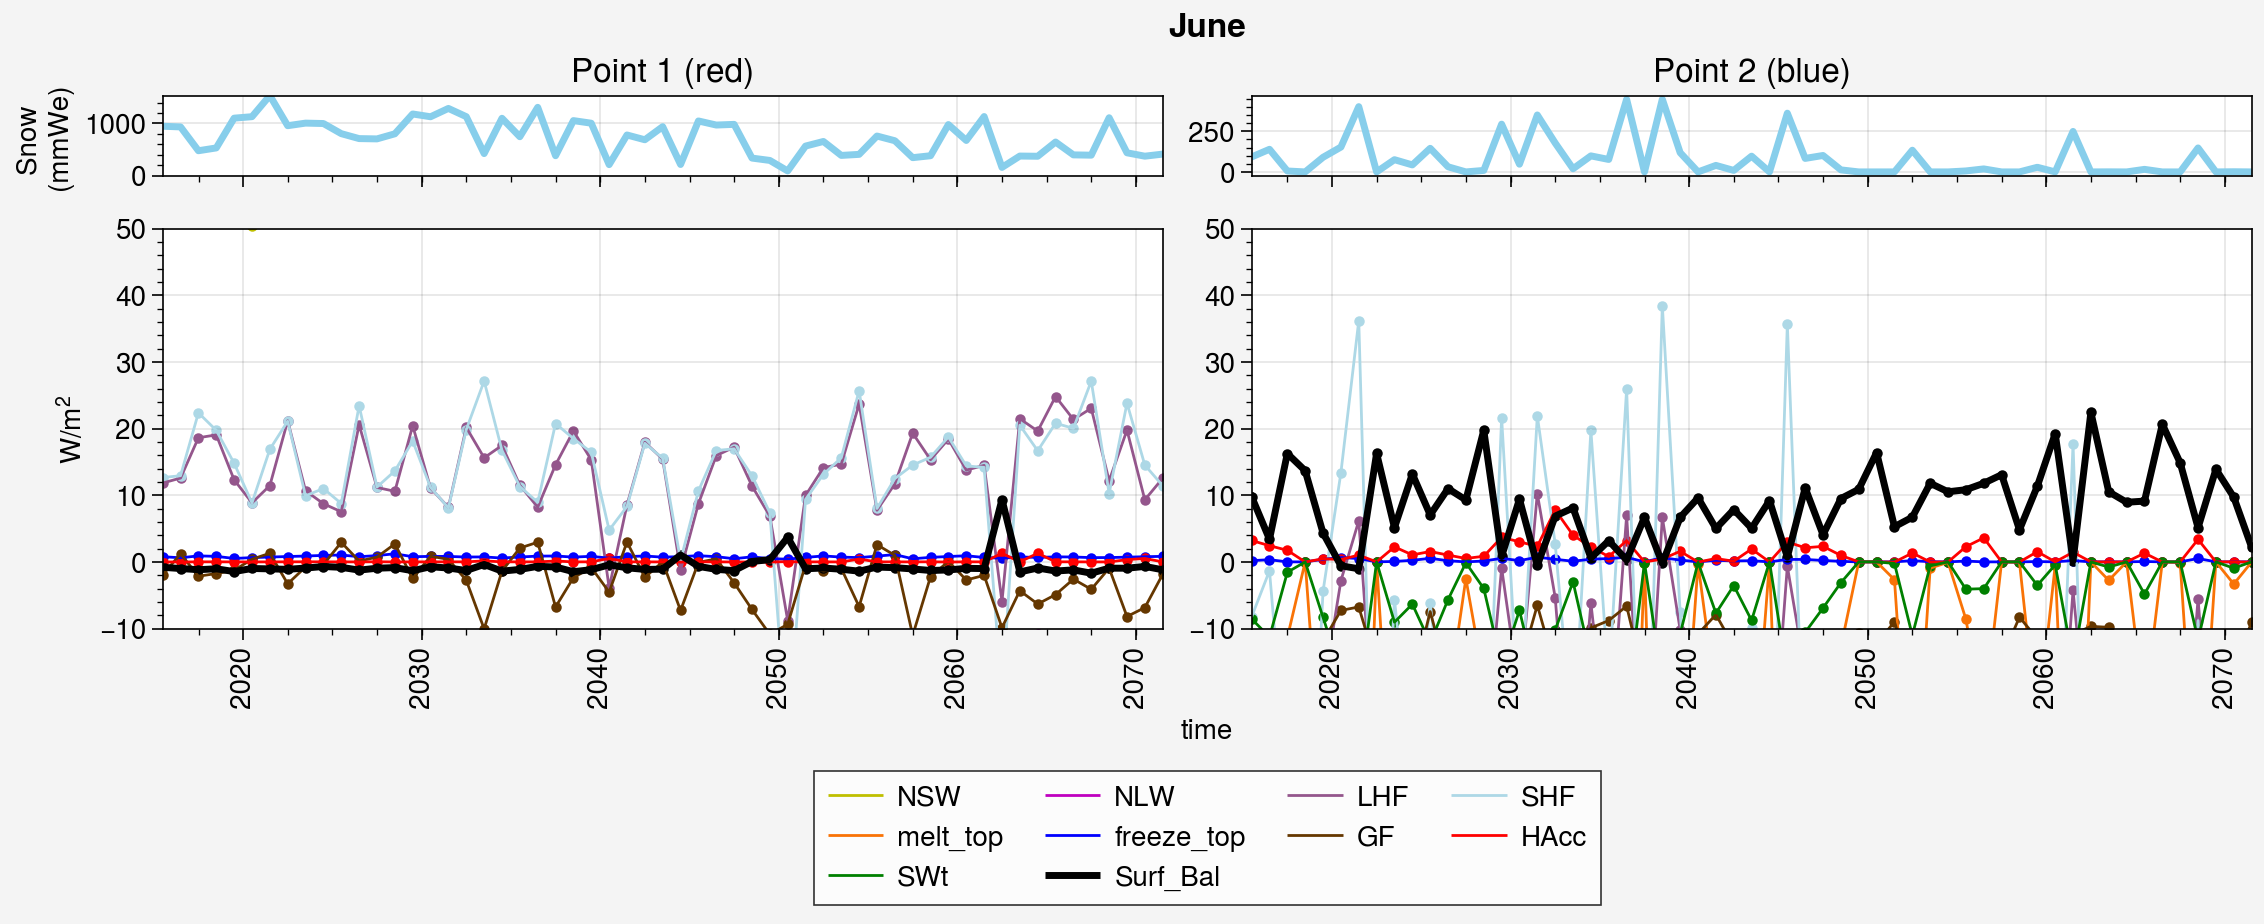

In [20]:
plot_monthly_2points(ds_mon_yrly, x_axis=ds_mon_yrly.time, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=25, ymin=-10, ymax=50,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='June')

In [54]:
ds_Feb = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Feb_surfbal.npy')

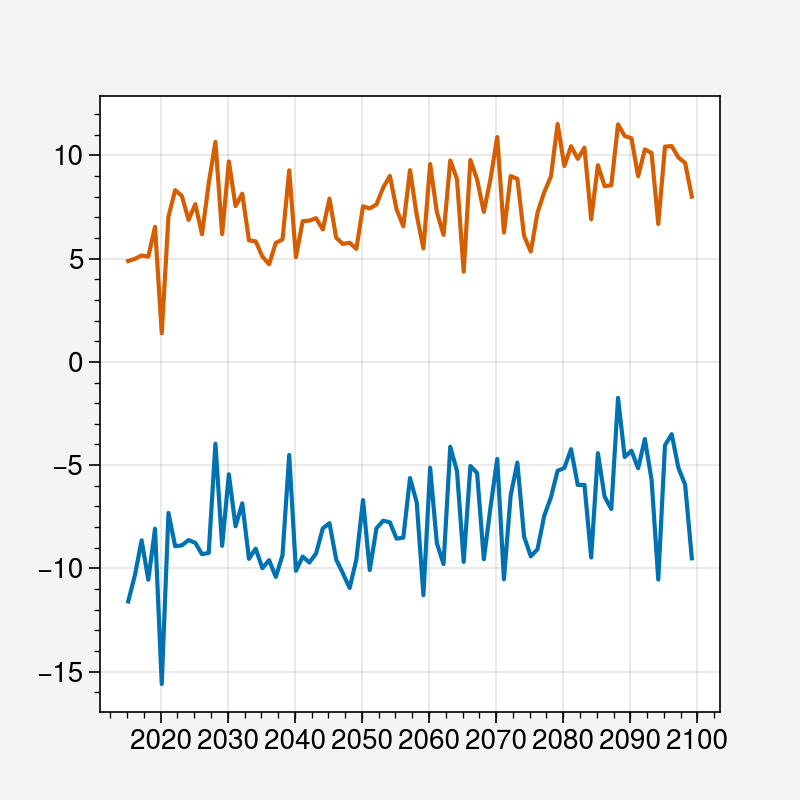

In [68]:
plt.plot(ds_Feb.time[:], np.array(ds_Feb['TTz'].sel(ztqlev=2))[:,50,50])

plt.plot(ds_Feb.time[:], np.array(ds_Feb['TTz'].sel(ztqlev=2))[:,35,50])

## As a function of altitude

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


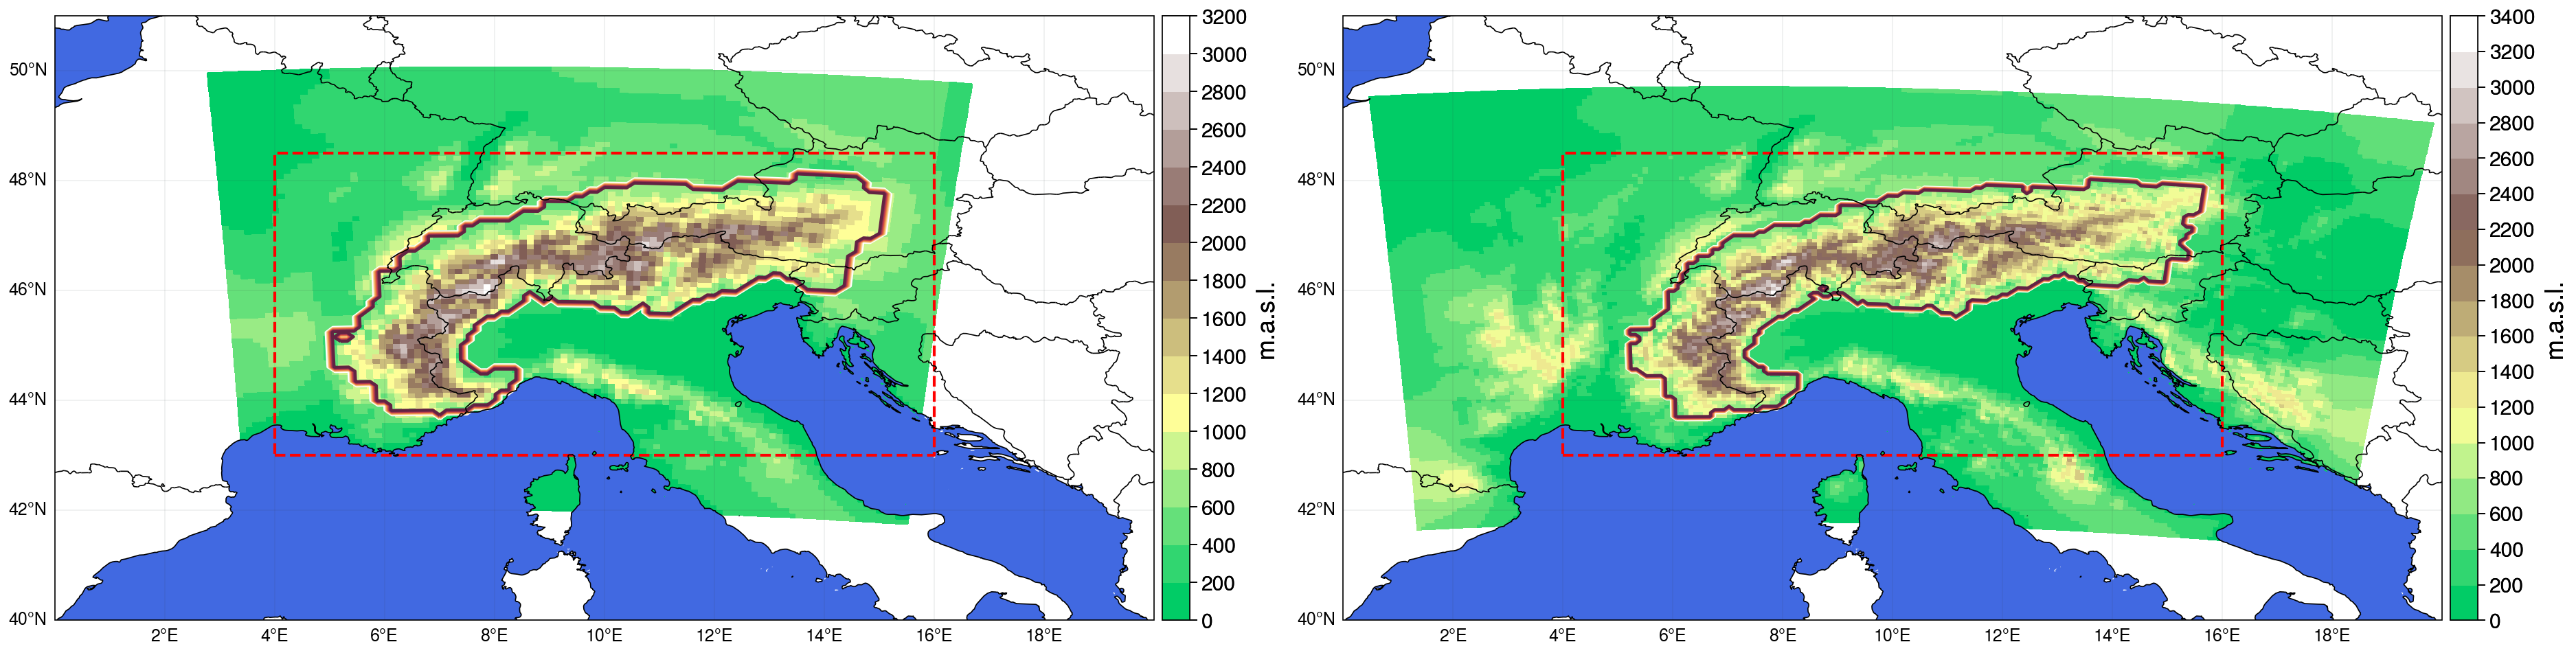

In [11]:
pplt.rc['figure.facecolor'] = 'white'

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)
m=axs[0].pcolormesh(ds_smallish.LON, ds_smallish.LAT, ds_smallish.SH, levels=17,cmap=colors_land)
axs[0].colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')
axs[0].plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs[0].contour(lon_smallish, lat_smallish, alps_smallish)

m=axs[1].pcolormesh(ds.LON, ds.LAT, ds.SH, levels=17,cmap=colors_land)
axs[1].colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')
axs[1].plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs[1].contour(lon, lat, alps)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])


In [13]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/'
ds_yrs = xr.open_dataset(path + 'ds_Surfbal_vars_seas_2015_2100_MB.npy') #.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

ds_yrs

<xarray.Dataset>
Dimensions:     (x: 100, y: 90, ztqlev: 3, sector: 3, Year: 86, season: 4)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * sector      (sector) float32 1.0 2.0 3.0
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables: (12/16)
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    ...          ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...
    NSW         (Year, season, y, x) float64 ...
    NLW         (Year, season, y, x) float64 ...
    Surfbal     (Year, season, y, x) float64 ...
    MB          (Year, season, sector, y, x) float64 ...

In [14]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/STlim30/'
ds_yrs2 = xr.open_dataset(path + 'ds_Surfbal_vars_seas_2015_2100.npy')

ds_yrs2

<xarray.Dataset>
Dimensions:     (x: 100, y: 90, ztqlev: 3, sector: 3, atmlay: 2, Year: 86,
                 season: 4)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * sector      (sector) float32 1.0 2.0 3.0
  * atmlay      (atmlay) float32 0.9997 0.9995
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables: (12/18)
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    ...          ...
    TTmax       (Year, season, atmlay, y, x) float64 ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...
    NSW         (Year, season, y, x) float64 ...
    NLW         (Year, season, y, x) float64 ...
    Surfbal     (Year, season, y, x) float64 ...

In [10]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/'
ds_yrsv310 = xr.open_dataset(path + 'ds_Surfbal_vars_2015_2100_seas.npy').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

ds_yrsv310

<xarray.Dataset>
Dimensions:  (x: 201, y: 126, ztqlev: 4, sector: 3, atmlay: 3, Year: 86,
              season: 4)
Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
  * sector   (sector) float32 1.0 2.0 3.0
  * atmlay   (atmlay) float32 0.9997 0.9995 0.999
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year     (Year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables: (12/14)
    LWD      (Year, season, y, x) float64 ...
    LWU      (Year, season, y, x) float64 ...
    SWD      (Year, season, y, x) float64 ...
    SWU      (Year, season, y, x) float64 ...
    SHF      (Year, season, y, x) float64 ...
    LHF      (Year, season, y, x) float64 ...
    ...       ...
    TTmin    (Year, season, atmlay, y, x) float64 ...
    TTmax    (Year, season, atmlay, y, x) float64 ...
    melt     (Year, season, y, x) float64 ...
    NSW      (Year, season, y, x) float64 ...
    NLW      (Year, season, y, x) float64 ...
    Surfbal  (Year, season, y, x) float64 ...

In [13]:
# yrs = np.arange(2015,2101)

# ds_yrsv310 = ds_yrsv310.assign_coords(Year=("Year", yrs))

# ds_yrsv310['NSW'] = ds_yrsv310['SWD'] - ds_yrsv310['SWU']
# ds_yrsv310['NLW'] = ds_yrsv310['LWD'] - ds_yrsv310['LWU']
# #ds_yrs['SWt'] = - ds_yrs['SWt'] # - sign for SWt because the energy transmitted to lower layers is LOST by the surface
# ds_yrsv310['Surfbal'] = ds_yrsv310['NSW'] + ds_yrsv310['NLW'] + ds_yrsv310['SHF'] + ds_yrsv310['LHF'] + ds_yrsv310['melt']

In [12]:
# ds_yrsv310.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds_Surfbal_vars_2015_2100_seas.npy')

In [15]:
# ds_yrs.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


<xarray.Dataset>
Dimensions:     (x: 100, y: 90, ztqlev: 3, sector: 3, Year: 86, season: 4)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * sector      (sector) float32 1.0 2.0 3.0
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables: (12/16)
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    ...          ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...
    NSW         (Year, season, y, x) float64 ...
    NLW         (Year, season, y, x) float64 ...
    Surfbal     (Year, season, y, x) float64 ...
    MB          (Year, season, sector, y, x) float64 ...

In [32]:
ds_yrs

<xarray.Dataset>
Dimensions:     (x: 100, y: 90, ztqlev: 3, sector: 3, atmlay: 2, Year: 86,
                 season: 4)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * sector      (sector) float32 1.0 2.0 3.0
  * atmlay      (atmlay) float32 0.9997 0.9995
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables: (12/18)
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    ...          ...
    TTmax       (Year, season, atmlay, y, x) float64 ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...
    NSW         (Year, season, y, x) float64 0.0 102.1 102.1 ... 123.9 123.9 0.0
    NLW         (Year, season, y, x) float64 0.0 267.1 266.8 ... 289.1 289.3 0.0
    Surfbal     (Year, season, y, x) float64 0.0 369.3 368.9 ... 413.0 413.2 0.0

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_2449131/2383739220.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_2449131/2383739220.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


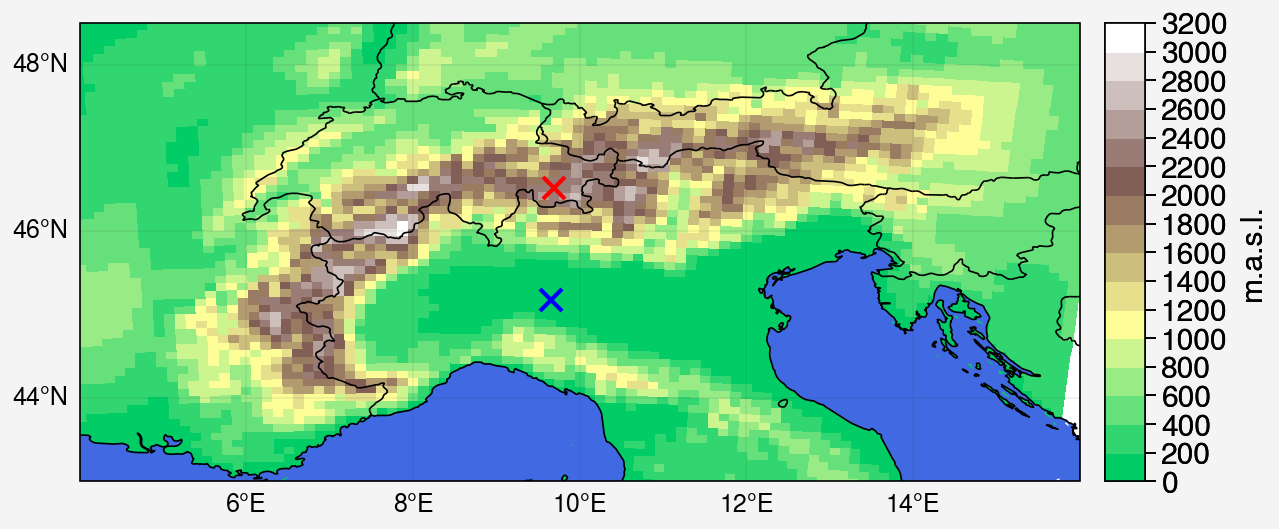

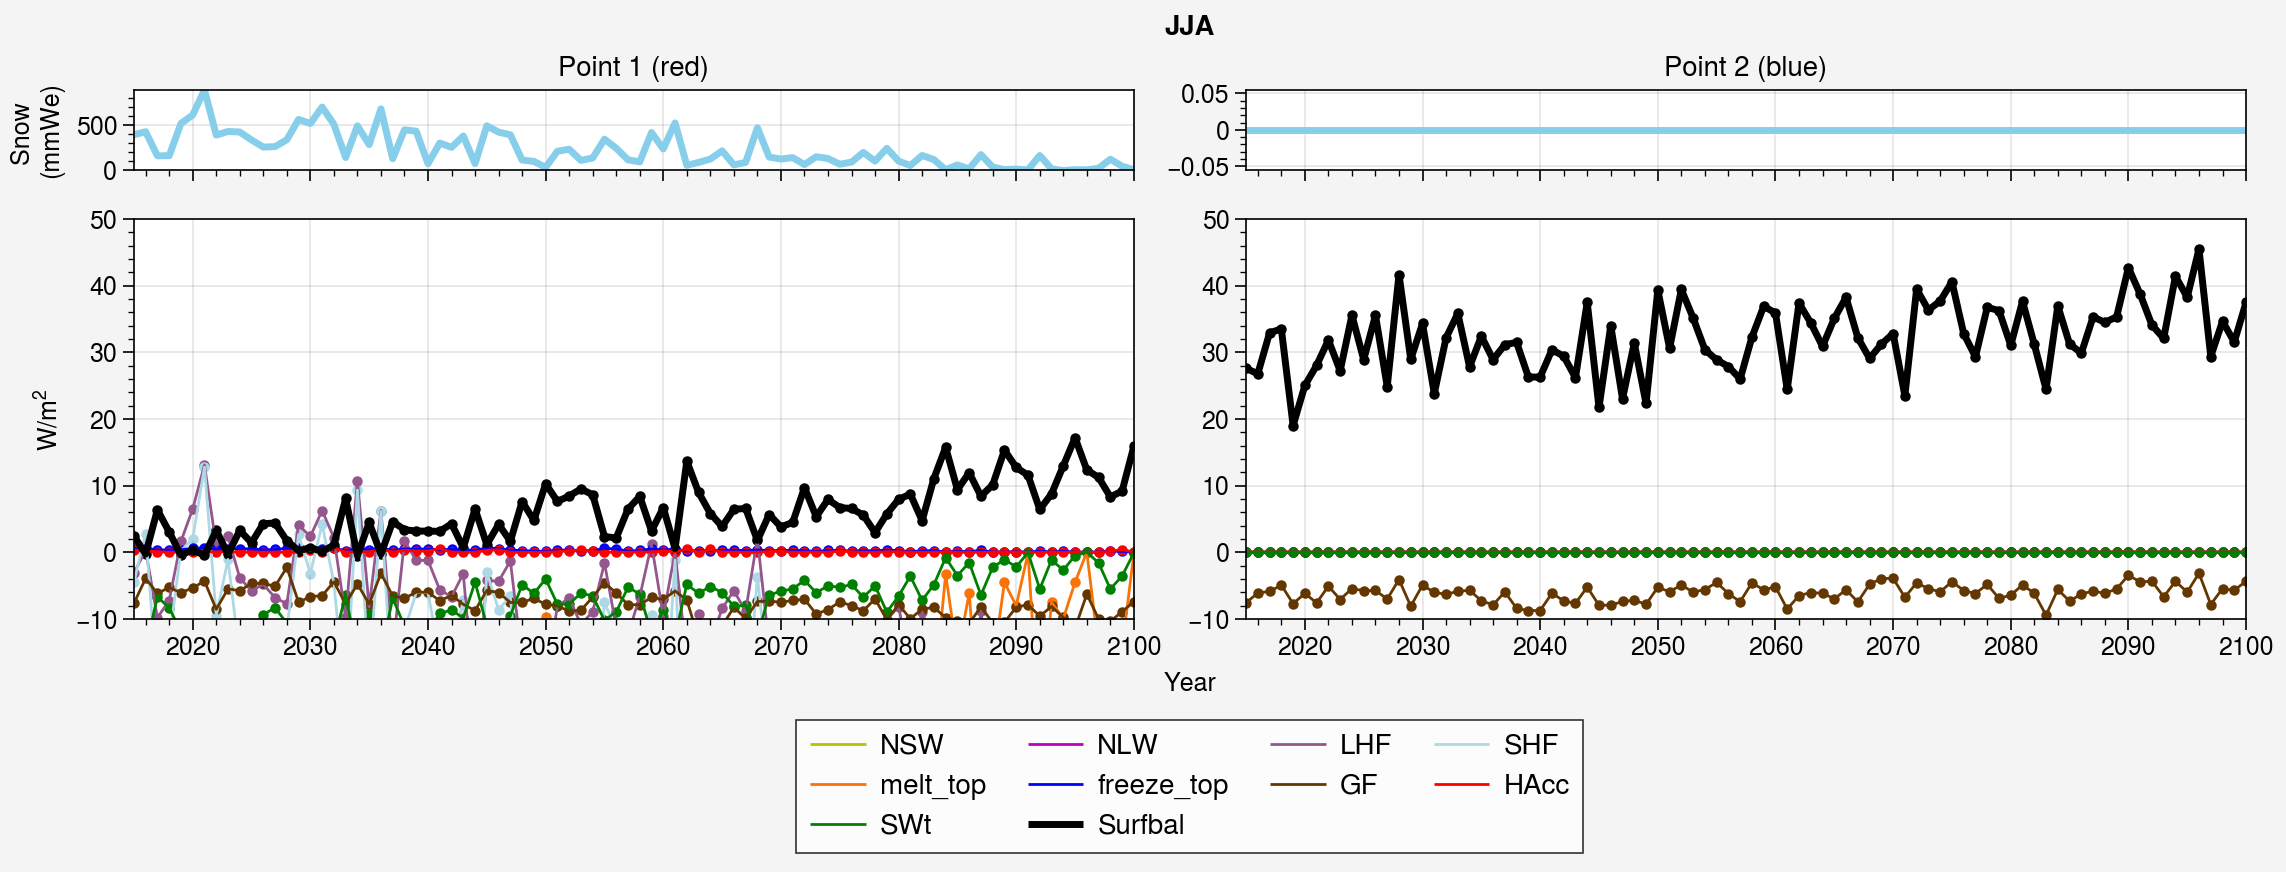

In [16]:
plot_monthly_2points(ds_yrs.sel(season='JJA'), x_axis=ds_yrs.Year, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=50, ymin=-10, ymax=50,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surfbal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='JJA')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_3121828/2383739220.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_3121828/2383739220.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


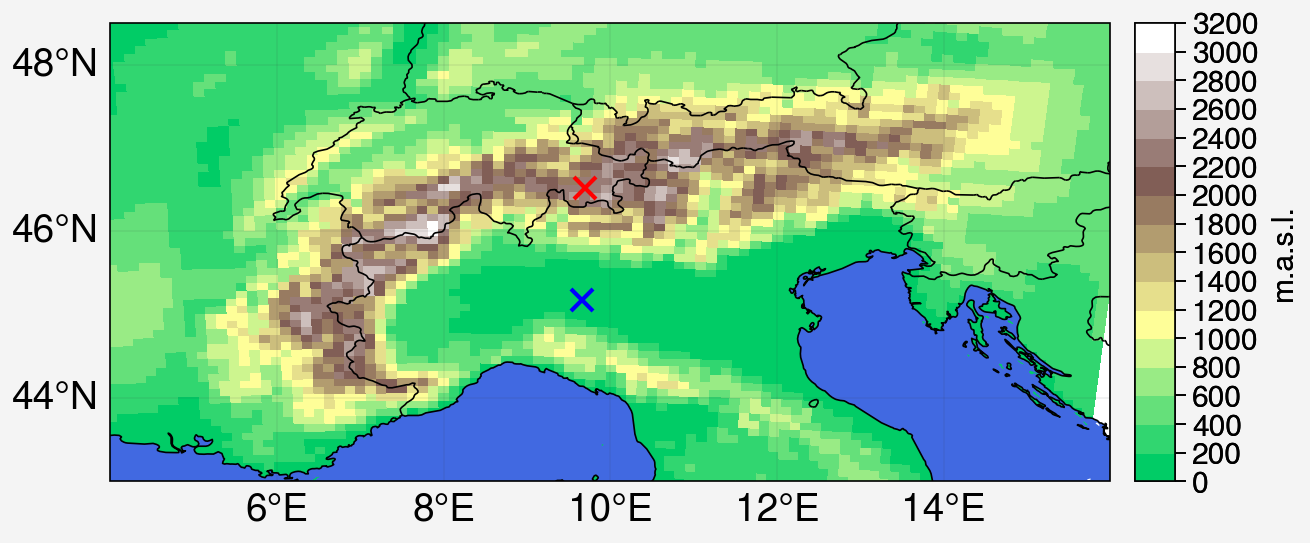

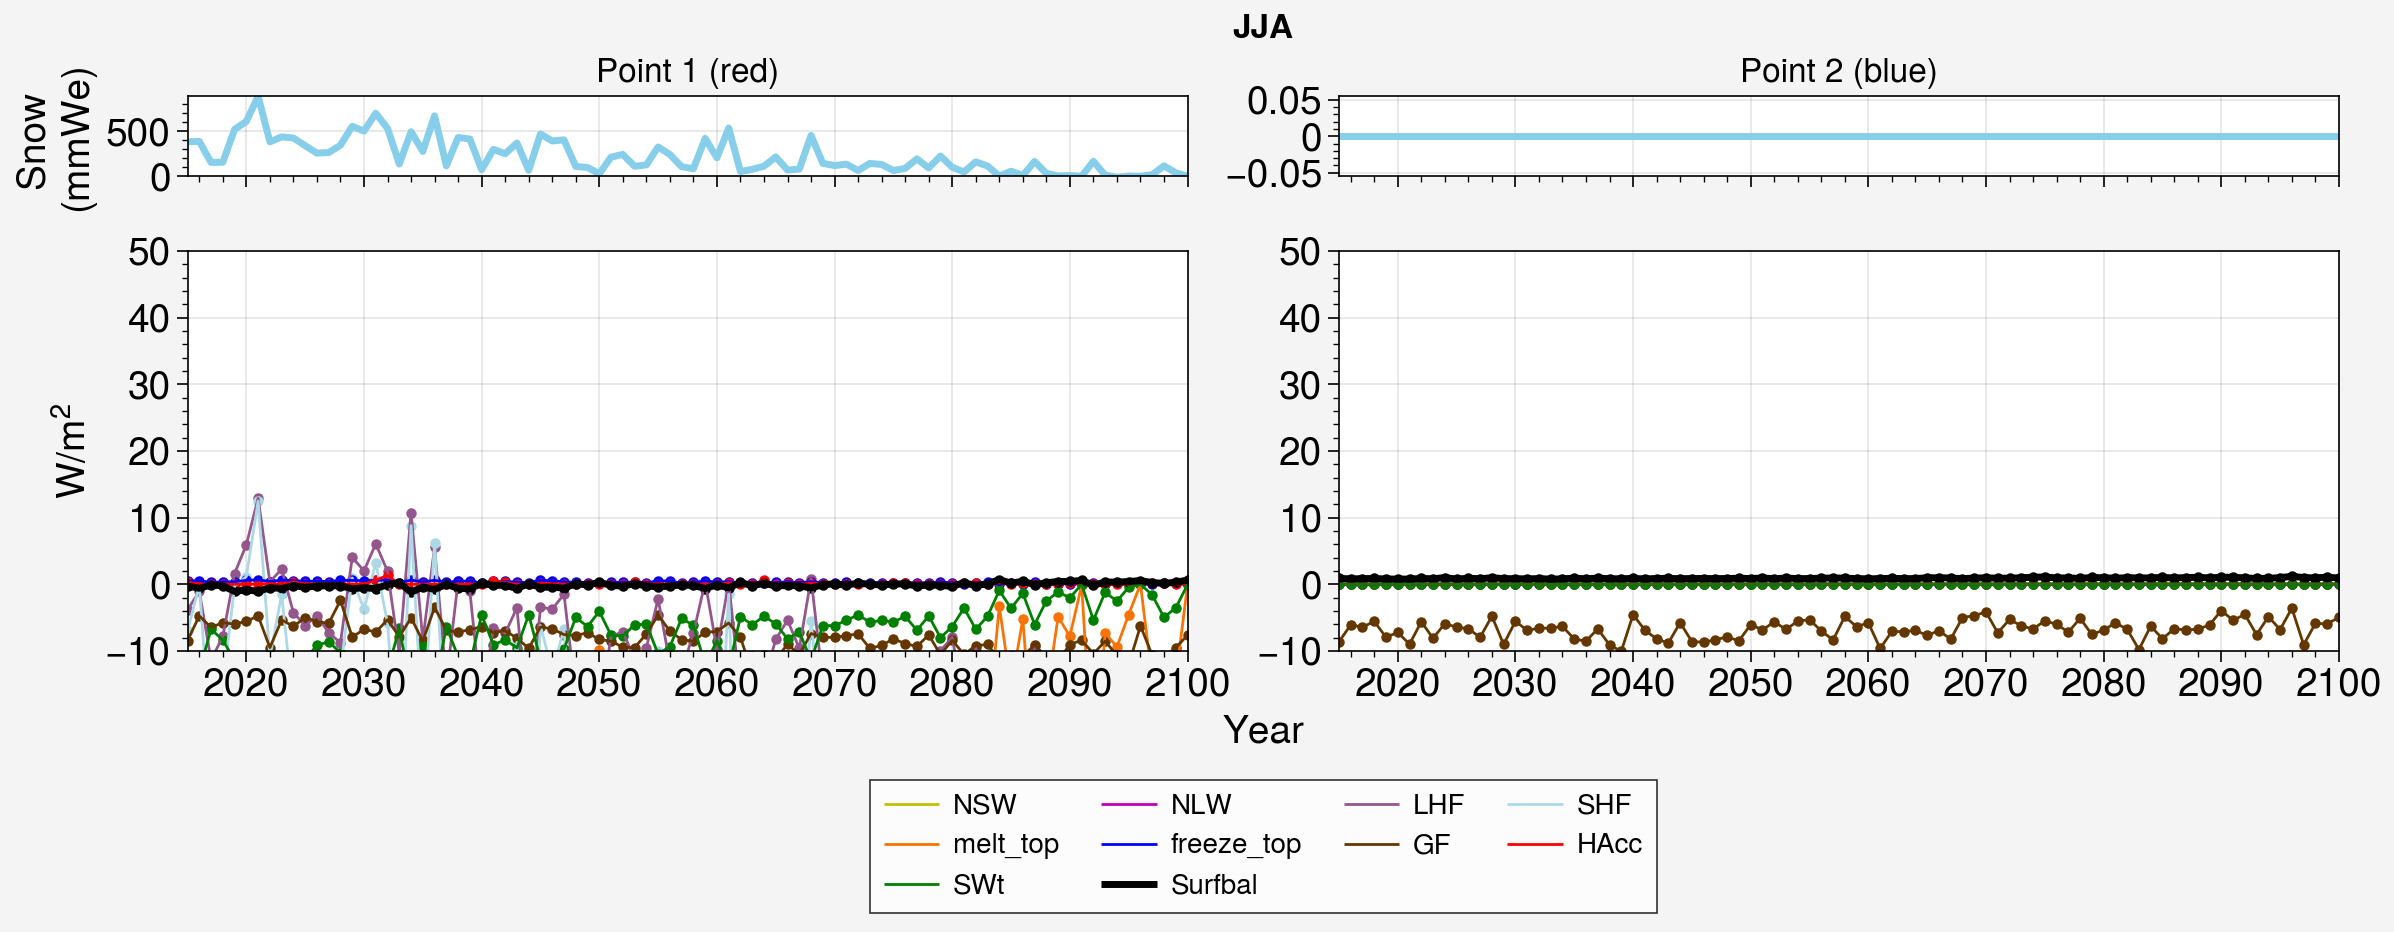

In [37]:
plot_monthly_2points(ds_yrs2.sel(season='JJA'), x_axis=ds_yrs2.Year, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=50, ymin=-10, ymax=50,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surfbal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='JJA')

In [19]:
ds_slopes = ds_yrs.polyfit('Year', deg=1)
ds_slopes

<xarray.Dataset>
Dimensions:                          (season: 4, y: 90, x: 100, degree: 2,
                                      ztqlev: 3, sector: 3)
Coordinates:
  * season                           (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * y                                (y) float32 -440.0 -430.0 ... 440.0 450.0
  * x                                (x) float32 -370.0 -360.0 ... 610.0 620.0
  * degree                           (degree) int64 1 0
  * ztqlev                           (ztqlev) float32 2.0 10.0 100.0
  * sector                           (sector) float32 1.0 2.0 3.0
Data variables: (12/16)
    LWD_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    LWU_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SWD_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SWU_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SHF_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    LHF_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    ...                               ...
    melt_top_polyfit_coefficients    (degree, season, y, x) float64 0.0 ... 0.0
    freeze_top_polyfit_coefficients  (degree, season, y, x) float64 0.0 ... 0.0
    NSW_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    NLW_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    Surfbal_polyfit_coefficients     (degree, season, y, x) float64 0.0 ... 0.0
    MB_polyfit_coefficients          (degree, season, sector, y, x) float64 0...

/tmp/ipykernel_3121828/122561156.py:11: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend()


(<matplotlib.legend.Legend at 0x14d6439f48e0>,
 <matplotlib.legend.Legend at 0x14d643827a30>)

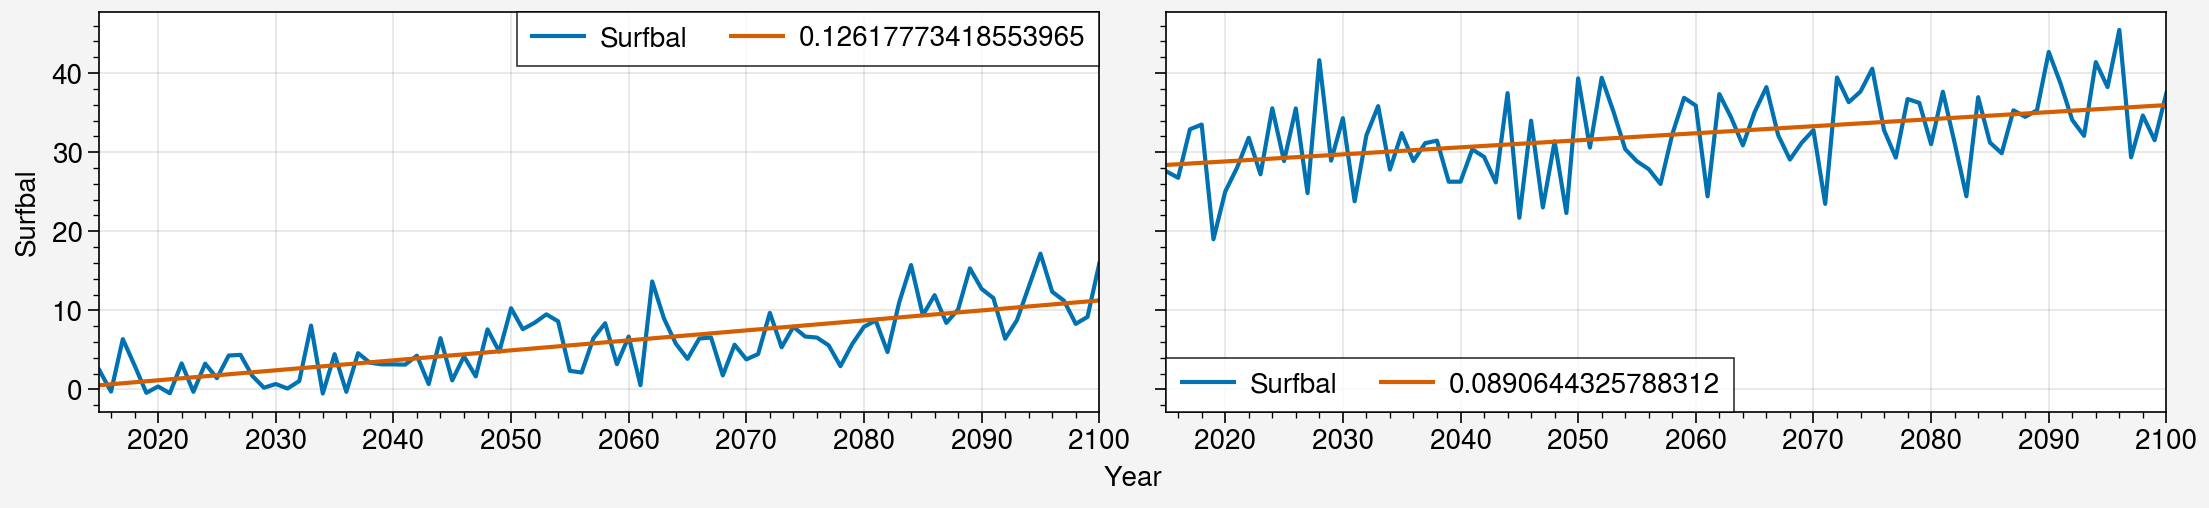

In [20]:
f,axs = pplt.subplots(ncols=2,axwidth=5,axheight=2)

axs[0].plot(ds_yrs.sel(season='JJA').Surfbal[:,50,50])
axs[0].plot(ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,50,50]*ds_yrs.Year + ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[1,50,50],
            label=ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,50,50])

axs[1].plot(ds_yrs.sel(season='JJA').Surfbal[:,35,50])
axs[1].plot(ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,35,50]*ds_yrs.Year + ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[1,35,50],
           label=ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,35,50])

axs.legend()

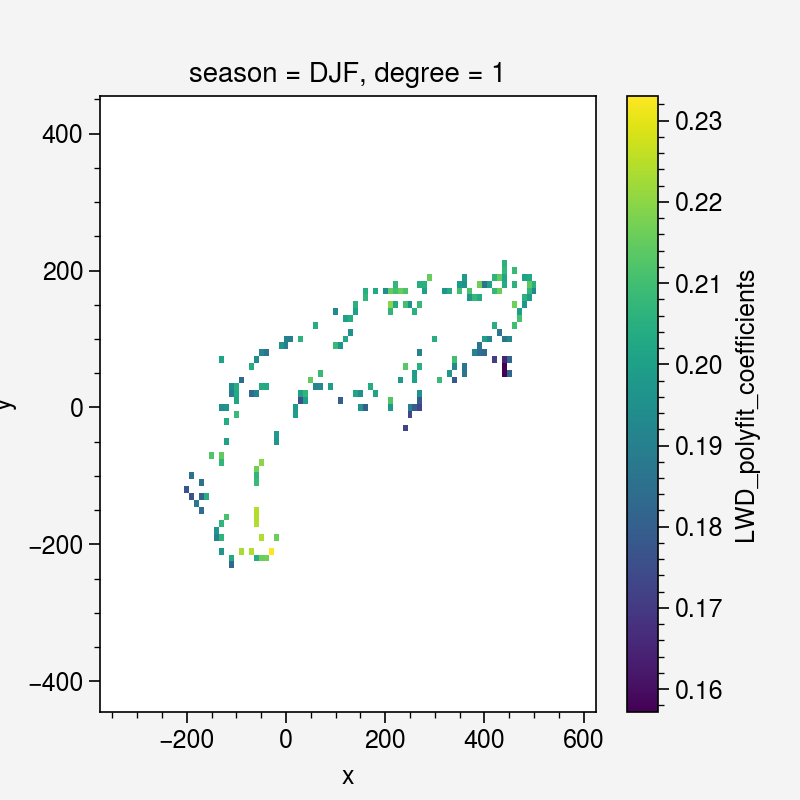

In [42]:
ds_slopes.LWD_polyfit_coefficients.sel(season='DJF',degree=1).where(levels[5]).plot()

In [28]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]

alps = alps_smallish
H = ds_smallish.SH

levels_smallish = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]

H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]

In [22]:
ds_slopes_Hlev = ds_slopes.where(levels[0]).mean(dim=('x','y'))
ds_slopes_Hlev_std = ds_slopes.where(levels[0]).std(dim=('x','y'))

for lev in range(1,len(levels)):
    ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,ds_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
    ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,ds_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", H_levels))
ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", H_levels))

In [23]:
ds_slopes_Hlev

<xarray.Dataset>
Dimensions:                          (Hlev: 15, degree: 2, season: 4,
                                      ztqlev: 3, sector: 3)
Coordinates:
  * season                           (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * degree                           (degree) int64 1 0
  * ztqlev                           (ztqlev) float32 2.0 10.0 100.0
  * sector                           (sector) float32 1.0 2.0 3.0
  * Hlev                             (Hlev) int64 300 500 700 ... 2700 2900 3100
Data variables: (12/16)
    LWD_polyfit_coefficients         (Hlev, degree, season) float64 0.2141 .....
    LWU_polyfit_coefficients         (Hlev, degree, season) float64 0.2244 .....
    SWD_polyfit_coefficients         (Hlev, degree, season) float64 -0.005736...
    SWU_polyfit_coefficients         (Hlev, degree, season) float64 -0.007939...
    SHF_polyfit_coefficients         (Hlev, degree, season) float64 -0.008777...
    LHF_polyfit_coefficients         (Hlev, degree, season) float64 -0.000608...
    ...                               ...
    melt_top_polyfit_coefficients    (Hlev, degree, season) float64 0.009918 ...
    freeze_top_polyfit_coefficients  (Hlev, degree, season) float64 -0.000683...
    NSW_polyfit_coefficients         (Hlev, degree, season) float64 0.002203 ...
    NLW_polyfit_coefficients         (Hlev, degree, season) float64 -0.01036 ...
    Surfbal_polyfit_coefficients     (Hlev, degree, season) float64 -0.000161...
    MB_polyfit_coefficients          (Hlev, degree, season, sector) float64 -...

In [34]:
ds_slopes_Hlev['TTz_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)

<xarray.DataArray 'TTz_polyfit_coefficients' (Hlev: 15)>
array([0.05000764, 0.05040918, 0.05114425, 0.05160947, 0.05162136,
       0.05197469, 0.05238076, 0.05281676, 0.05354883, 0.05439117,
       0.05554345, 0.05631062, 0.05728061, 0.06107313, 0.06435595])
Coordinates:
    season   <U3 'SON'
    degree   int64 1
    ztqlev   float32 2.0
  * Hlev     (Hlev) int64 300 500 700 900 1100 1300 ... 2300 2500 2700 2900 3100

In [26]:
names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k']

In [25]:
def altitude_lev_slopes(dataset_slopes,levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", H_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", H_levels))

    return ds_slopes_Hlev, ds_slopes_Hlev_std

In [56]:
ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax))#.melt[:,:,80,:]#.polyfit('Year', deg=1).values

<xarray.Dataset>
Dimensions:  (x: 139, y: 91, ztqlev: 4, sector: 3, atmlay: 3, Year: 86,
              season: 4)
Coordinates:
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
  * sector   (sector) float32 1.0 2.0 3.0
  * atmlay   (atmlay) float32 0.9997 0.9995 0.999
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year     (Year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables: (12/14)
    LWD      (Year, season, y, x) float64 ...
    LWU      (Year, season, y, x) float64 ...
    SWD      (Year, season, y, x) float64 ...
    SWU      (Year, season, y, x) float64 ...
    SHF      (Year, season, y, x) float64 ...
    LHF      (Year, season, y, x) float64 ...
    ...       ...
    TTmin    (Year, season, atmlay, y, x) float64 ...
    TTmax    (Year, season, atmlay, y, x) float64 ...
    melt     (Year, season, y, x) float64 ...
    NSW      (Year, season, y, x) float64 ...
    NLW      (Year, season, y, x) float64 ...
    Surfbal  (Year, season, y, x) float64 ...

In [67]:
simcode='y'

ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EU'+simcode+'.MBm.2015.nc')
np.array(ds_var.MBm)[0,1,:,20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [72]:
ds_var.MBm[:,0,0,20]

<xarray.DataArray 'MBm' (time: 365)>
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Coordinates:
    sector   float32 1.0
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
    x        float32 -343.0
    y        float32 -308.0
Attributes:
    units:          mmWE
    long_name:      Only Melting
    standard_name:  Only_Melting
    actual_range:   [ 0.       52.735874]
    cell_methods:   time: mean

In [14]:
ds_yrsv310_masked = ds_yrsv310.where(ds_yrsv310 != -np.inf)
np.array(ds_yrsv310_masked.melt[0,1,:,20])

array([            nan,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.60580466e-04,
       -3.30640698e-04, -4.35055473e-04, -1.35172354e-04,  0.00000000e+00,
       -4.83830632e-04, -2.84630565e-04, -3.58771610e-04, -3.20245294e-04,
        0.00000000e+00,             nan,  0.00000000e+00, -2.26884495e-04,
       -3.50608027e-04,  0.00000000e+00,  0.00000000e+00, -4.89581495e-04,
       -5.99244159e-04, -8.89510617e-05,  0.00000000e+00, -1.01840738e-04,
       -1.06826345e-02, -1.56906687e-02, -7.65862670e-01, -5.86734486e-01,
       -1.09252834e-01, -2.69579341e-02, -3.90746170e-03, -7.87534244e-03,
       -2.45385083e-02, -9.71935292e-03, -1.29315271e-01, -6.30077549e-01,
       -4.56866236e-01, -3.49536538e-01, -1.08463231e-01, -5.53444159e-02,
       -2.99713441e-02, -9.34816792e-02, -4.56773612e-01, -1.15326891e+00,
       -1.20731205e+00, -8.70879680e-01, -4.44157085e-01, -8.43063084e-01,
       -1.96361140e+00, -

In [89]:
ds_yrsv310.melt[0,0,0,-1]

<xarray.DataArray 'melt' ()>
array(-inf)
Coordinates:
    x        float32 917.0
    y        float32 -308.0
    season   <U3 'DJF'
    Year     int64 2015

In [11]:
ds_yrsv310 = ds_yrsv310.where(ds_yrsv310 != -np.inf)

ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).polyfit('Year', deg=1,skipna=True).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:                       (season: 4, y: 91, x: 139, degree: 2,
                                   ztqlev: 4, sector: 3, atmlay: 3)
Coordinates:
  * season                        (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * y                             (y) float32 -168.0 -161.0 ... 455.0 462.0
  * x                             (x) float32 -259.0 -252.0 ... 700.0 707.0
  * degree                        (degree) int64 1 0
  * ztqlev                        (ztqlev) float32 2.0 10.0 50.0 100.0
  * sector                        (sector) float32 1.0 2.0 3.0
  * atmlay                        (atmlay) float32 0.9997 0.9995 0.999
Data variables: (12/14)
    LWD_polyfit_coefficients      (degree, season, y, x) float64 0.2575 ... -...
    LWU_polyfit_coefficients      (degree, season, y, x) float64 0.1641 ... -...
    SWD_polyfit_coefficients      (degree, season, y, x) float64 0.01046 ... ...
    SWU_polyfit_coefficients      (degree, seas

In [20]:
ds_slopes.melt_polyfit_coefficients[:,0,0,0]

<xarray.DataArray 'melt_polyfit_coefficients' (degree: 2)>
array([nan, nan])
Coordinates:
    season   <U3 'DJF'
    y        float32 -168.0
    x        float32 -259.0
  * degree   (degree) int64 1 0

In [21]:
ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).melt[:,0,0,0]

<xarray.DataArray 'melt' (Year: 86)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    x        float32 -259.0
    y        float32 -168.0
    season   <U3 'DJF'
  * Year     (Year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [39]:
ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).Surfbal[:,1,80,50].polyfit('Year', deg=1).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:               (degree: 2)
Coordinates:
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree) float64 0.02342 -32.56>

In [16]:
ds_slopes = ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).polyfit('Year', deg=1,skipna=True)
ds_slopes


<xarray.Dataset>
Dimensions:                       (season: 4, y: 91, x: 139, degree: 2,
                                   ztqlev: 4, sector: 3, atmlay: 3)
Coordinates:
  * season                        (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * y                             (y) float32 -168.0 -161.0 ... 455.0 462.0
  * x                             (x) float32 -259.0 -252.0 ... 700.0 707.0
  * degree                        (degree) int64 1 0
  * ztqlev                        (ztqlev) float32 2.0 10.0 50.0 100.0
  * sector                        (sector) float32 1.0 2.0 3.0
  * atmlay                        (atmlay) float32 0.9997 0.9995 0.999
Data variables: (12/14)
    LWD_polyfit_coefficients      (degree, season, y, x) float64 0.2575 ... -...
    LWU_polyfit_coefficients      (degree, season, y, x) float64 0.1641 ... -...
    SWD_polyfit_coefficients      (degree, season, y, x) float64 0.01046 ... ...
    SWU_polyfit_coefficients      (degree, season, y, x) float64 0.00111 ... ...
    SHF_polyfit_coefficients      (degree, season, y, x) float64 0.2133 ... -...
    LHF_polyfit_coefficients      (degree, season, y, x) float64 0.07383 ... ...
    ...                            ...
    TTmin_polyfit_coefficients    (degree, season, atmlay, y, x) float64 0.04...
    TTmax_polyfit_coefficients    (degree, season, atmlay, y, x) float64 0.03...
    melt_polyfit_coefficients     (degree, season, y, x) float64 nan ... -0.6347
    NSW_polyfit_coefficients      (degree, season, y, x) float64 0.009351 ......
    NLW_polyfit_coefficients      (degree, season, y, x) float64 0.09341 ... ...
    Surfbal_polyfit_coefficients  (degree, season, y, x) float64 nan ... -25.5

In [22]:
ds_slopes.melt_polyfit_coefficients[0,1,50]

<xarray.DataArray 'melt_polyfit_coefficients' (x: 139)>
array([ 3.04564626e-03,  1.10225308e-03,  9.92856463e-04,  1.35313365e-03,
        1.65853655e-03,  2.35199564e-03,  5.30761507e-03,  9.08025656e-03,
        5.17753634e-03,  1.78479548e-03,  3.98727434e-04,  4.03744781e-04,
        9.41178931e-04,  1.37732794e-03,  1.89649234e-03,  2.59912240e-03,
        2.91066545e-03,  4.94698308e-03,  6.83278443e-03,  8.61905417e-03,
        1.54826865e-02,  1.77851083e-02,  2.10343090e-02,  1.09873840e-02,
        1.45281826e-03,  1.72775916e-03,  1.88328321e-03,  2.90987320e-03,
        1.16700720e-02,  2.99391112e-02,  9.59715882e-02,  7.52847594e-02,
        1.82364844e-01,  2.57457113e-01,  3.90374425e-02,  5.04955137e-03,
        2.79792488e-01,  1.18570650e-01,  1.10279975e-03,  1.73704591e-03,
        3.68118886e-02,  1.56414361e-01, -1.79559927e-01, -1.20709786e-01,
        1.33737128e-01,  2.13401062e-01,  1.90899932e-02,  2.01952731e-01,
        2.81002282e-01,  4.17250478e-02,  6.92917687e-02,  2.68250970e-01,
        1.69509304e-01,  4.69373765e-02,  5.31627217e-03,  9.54739101e-03,
        1.94495599e-02,  1.14013330e-03,  1.56839023e-02,  1.53226755e-01,
        6.48678211e-02,  2.26855448e-03,  8.12477472e-04,  5.45255009e-02,
        2.24535715e-03,  5.67376909e-03,  4.35023460e-03,  3.81934819e-03,
        7.49066956e-03,  2.38494105e-03,  7.36952564e-02,  7.24946454e-02,
        2.80538668e-02, -1.49768586e-01, -2.84336763e-01,  2.33007687e-01,
        1.02529503e-01,  2.49855343e-01,  3.02893593e-01,  4.29580151e-02,
        3.26566087e-04,  1.29375719e-03,  1.75053808e-02,  2.46758121e-01,
        1.55148209e-01,  2.69675910e-01,  2.44897323e-01,  4.72392664e-02,
        1.01487113e-01,  4.31122697e-02,  1.46123403e-02,  1.80626834e-04,
        1.17091670e-03,  5.21909448e-03,  7.25149437e-03,  6.45841634e-02,
        4.28432611e-03,  6.06760747e-04,  1.09166896e-03,  6.67443604e-04,
        4.61675068e-04,  2.79915398e-04,  1.85348596e-04,  1.79340554e-04,
        1.98438405e-04,  1.01946771e-04,  9.37366547e-05,  6.51521632e-04,
        1.62000303e-03,  6.94345279e-03,  1.65173131e-02,  1.98739151e-02,
        1.16060199e-02,  1.16189917e-02,  1.17180876e-02,  6.51718982e-03,
        4.78936494e-03,  4.94138606e-03,  4.79410348e-03,  3.72237471e-03,
        4.80639245e-03,  4.44147454e-03,  3.29722479e-03,  3.23136663e-03,
        3.54337569e-03,  3.71188413e-03,  2.74036970e-03,  2.52828444e-03,
        2.95823577e-03,  2.90755118e-03,  3.45866608e-03,  2.94683549e-03,
        1.86405693e-03,  2.64454504e-03,  4.26544417e-03,  2.00646618e-03,
        1.77361824e-03,  1.56694713e-03,  1.02429817e-03])
Coordinates:
    season   <U3 'MAM'
    y        float32 182.0
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
    degree   int64 1

/tmp/ipykernel_2618910/3920856299.py:15: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/3920856299.py:15: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/3920856299.py:60: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/3920856299.py:60: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/3920856299.py:100: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/3920856299.py:100: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)


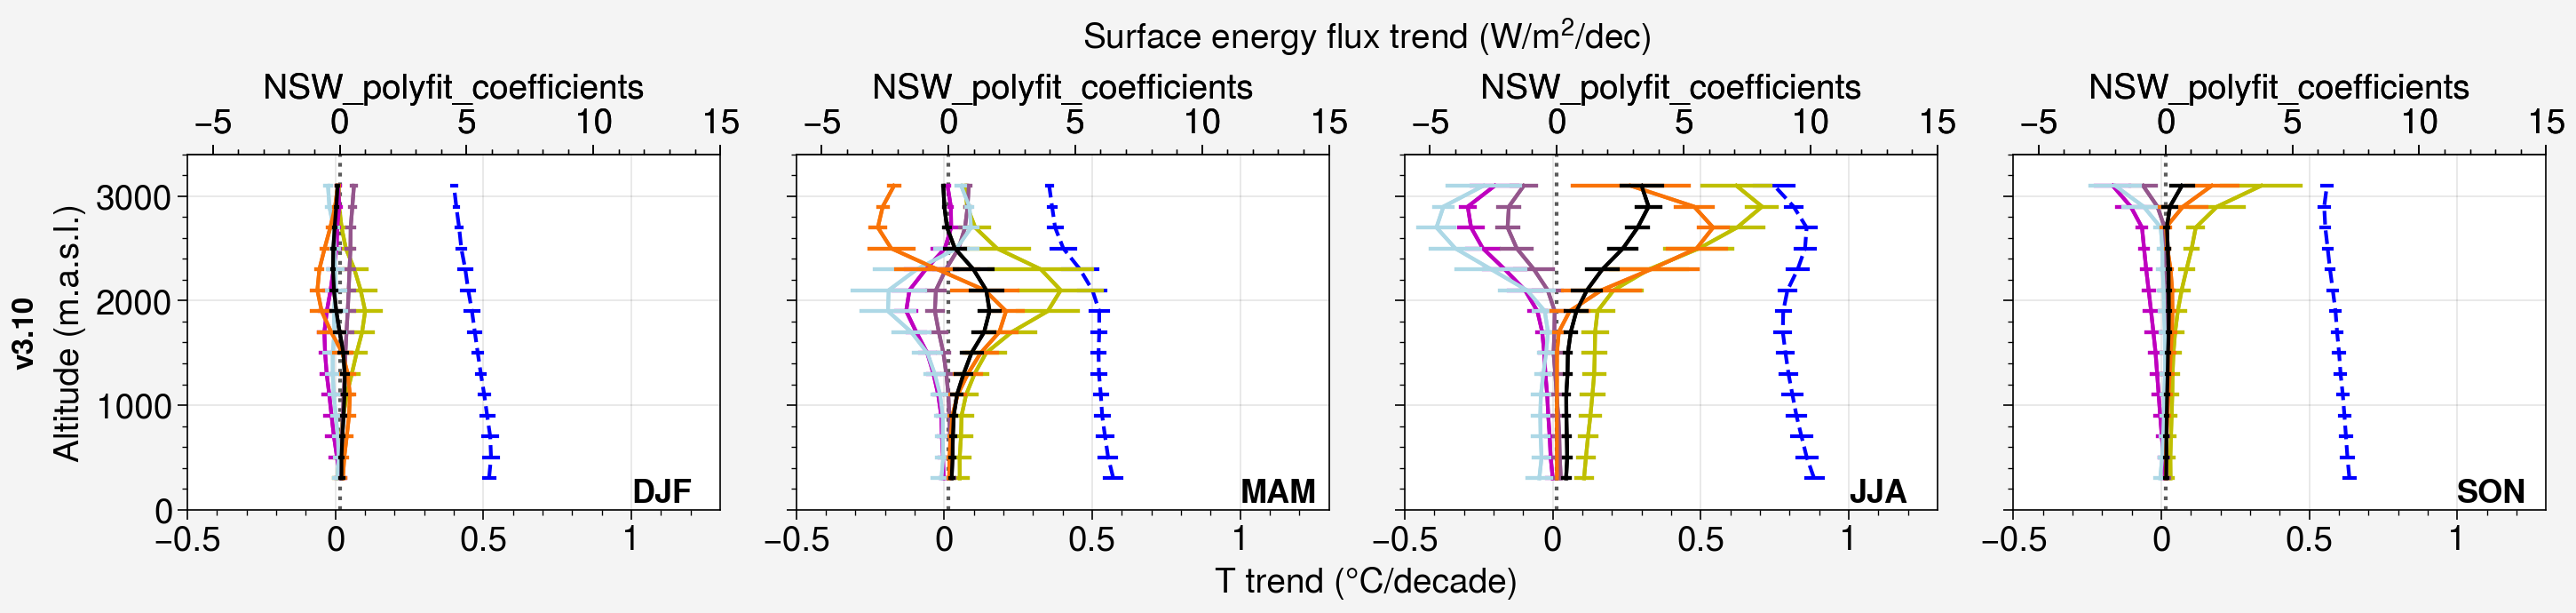

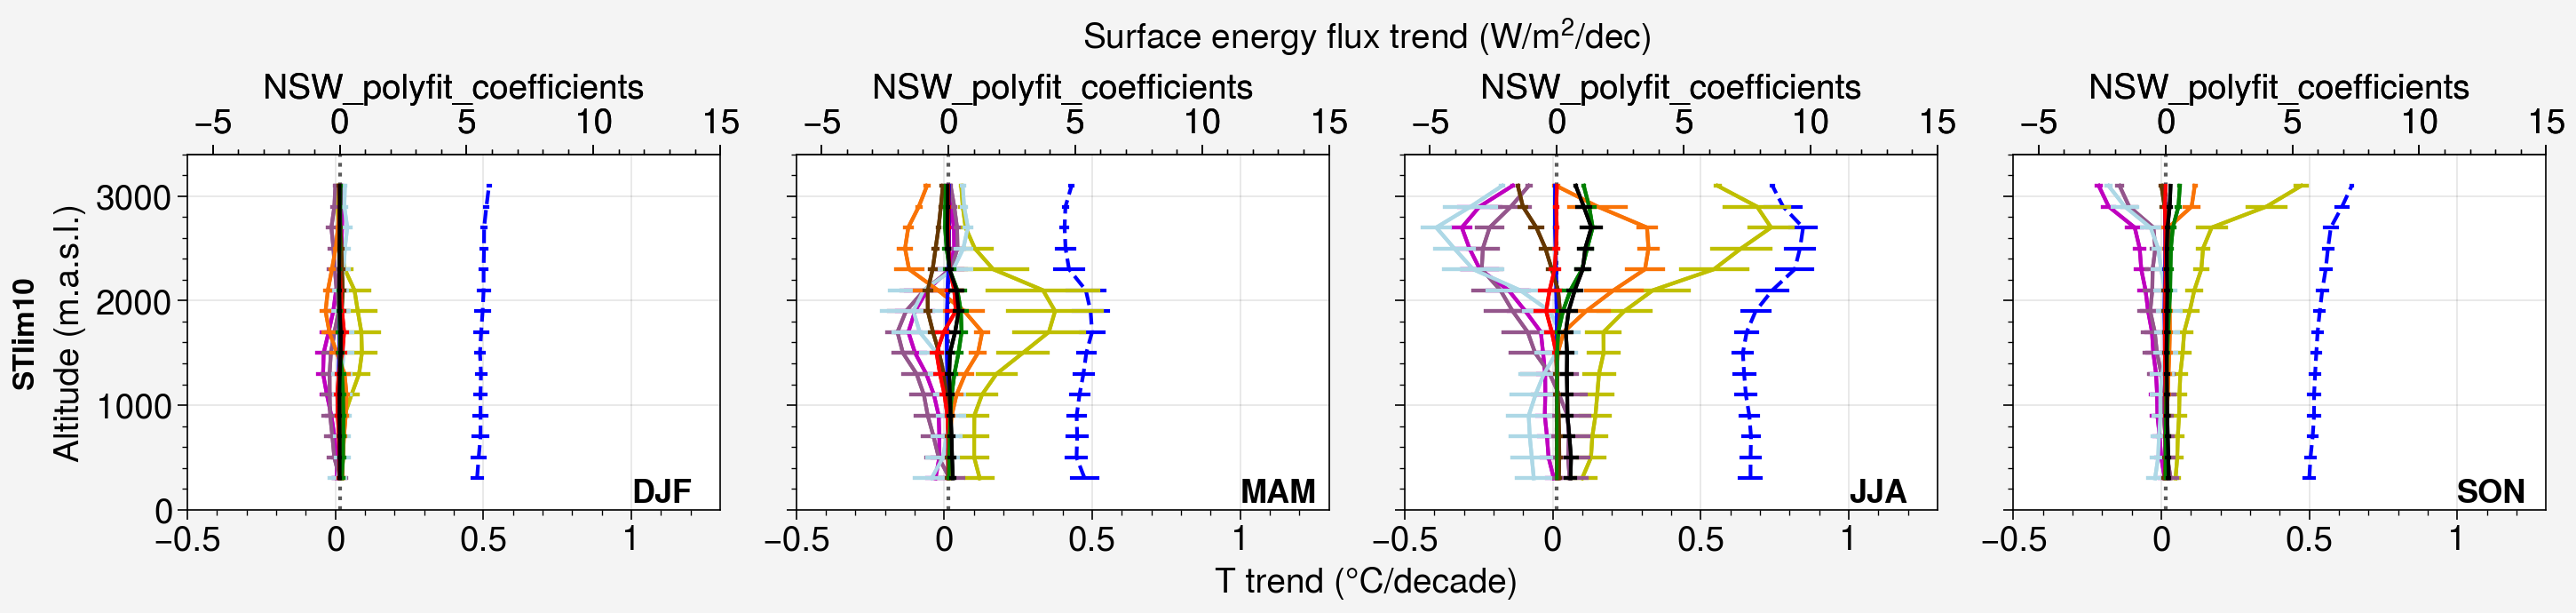

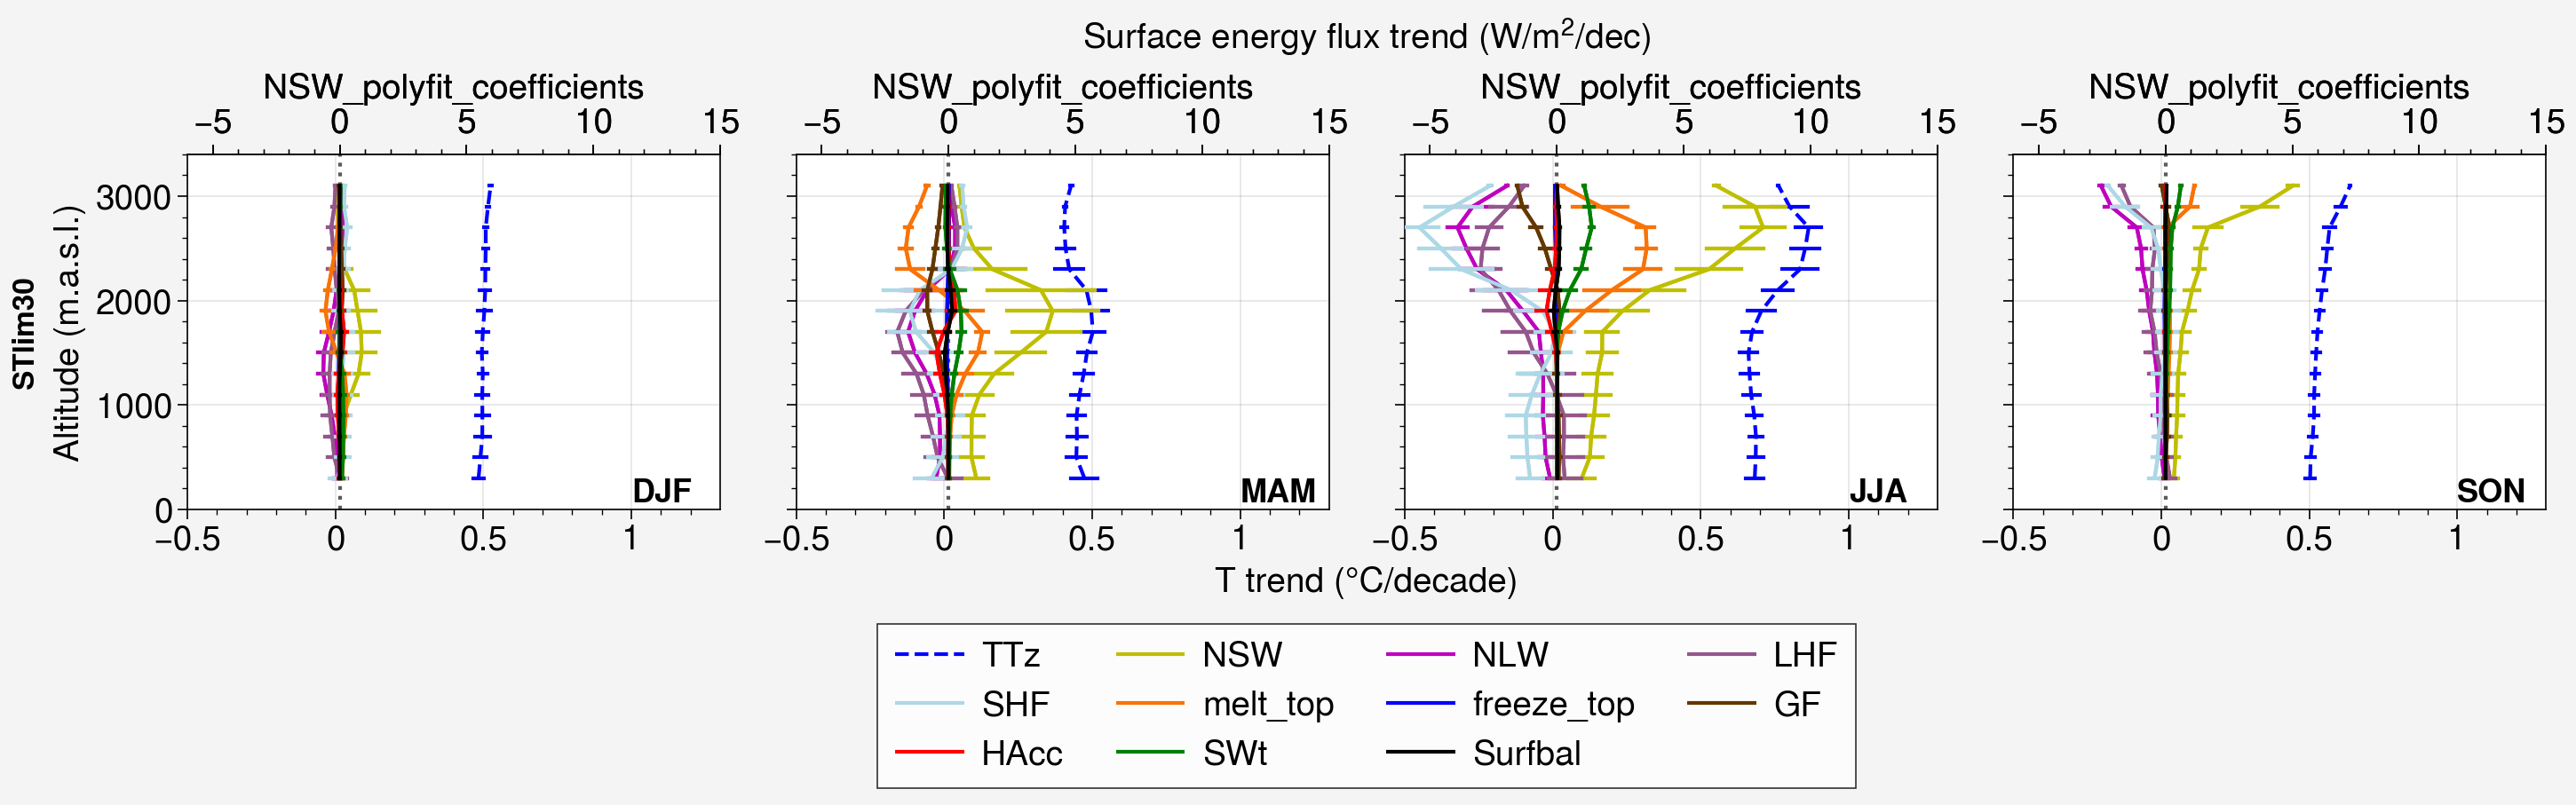

In [29]:
seasons=['DJF','MAM','JJA','SON']

multiplier = 10 # =10 if trends per decade

# ------------------------ v3.10 simulation ----------------------------

colors = ['b','y','m','purple','lightblue','orange','k']
leg_labels_null = ['','','','','','','']
leg_labels_full = ['TTz','NSW','NLW','LHF','SHF','melt','Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

ds_slopes = ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3,axheight=2)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-6,15)

#f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle,rowlabels=['v3.10'])

# ------------------------ STlim10 simulation ----------------------------

colors = ['b','y','m','purple','lightblue','orange','blue','brown','r','green','k']
leg_labels_null = ['','','','','','','','','','','']
leg_labels_full = ['TTz','NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

ds_slopes = ds_yrs.polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels_smallish)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3,axheight=2)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-6,15)

#f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle,rowlabels=['STlim10'])

# -------------------------------- STlim30 simulation --------------------------------------

ds_slopes = ds_yrs2.polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels_smallish)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3,axheight=2)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-6,15)

f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle,rowlabels=['STlim30'])

/tmp/ipykernel_2618910/1279517957.py:17: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/1279517957.py:17: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/1279517957.py:62: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_2618910/1279517957.py:62: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)


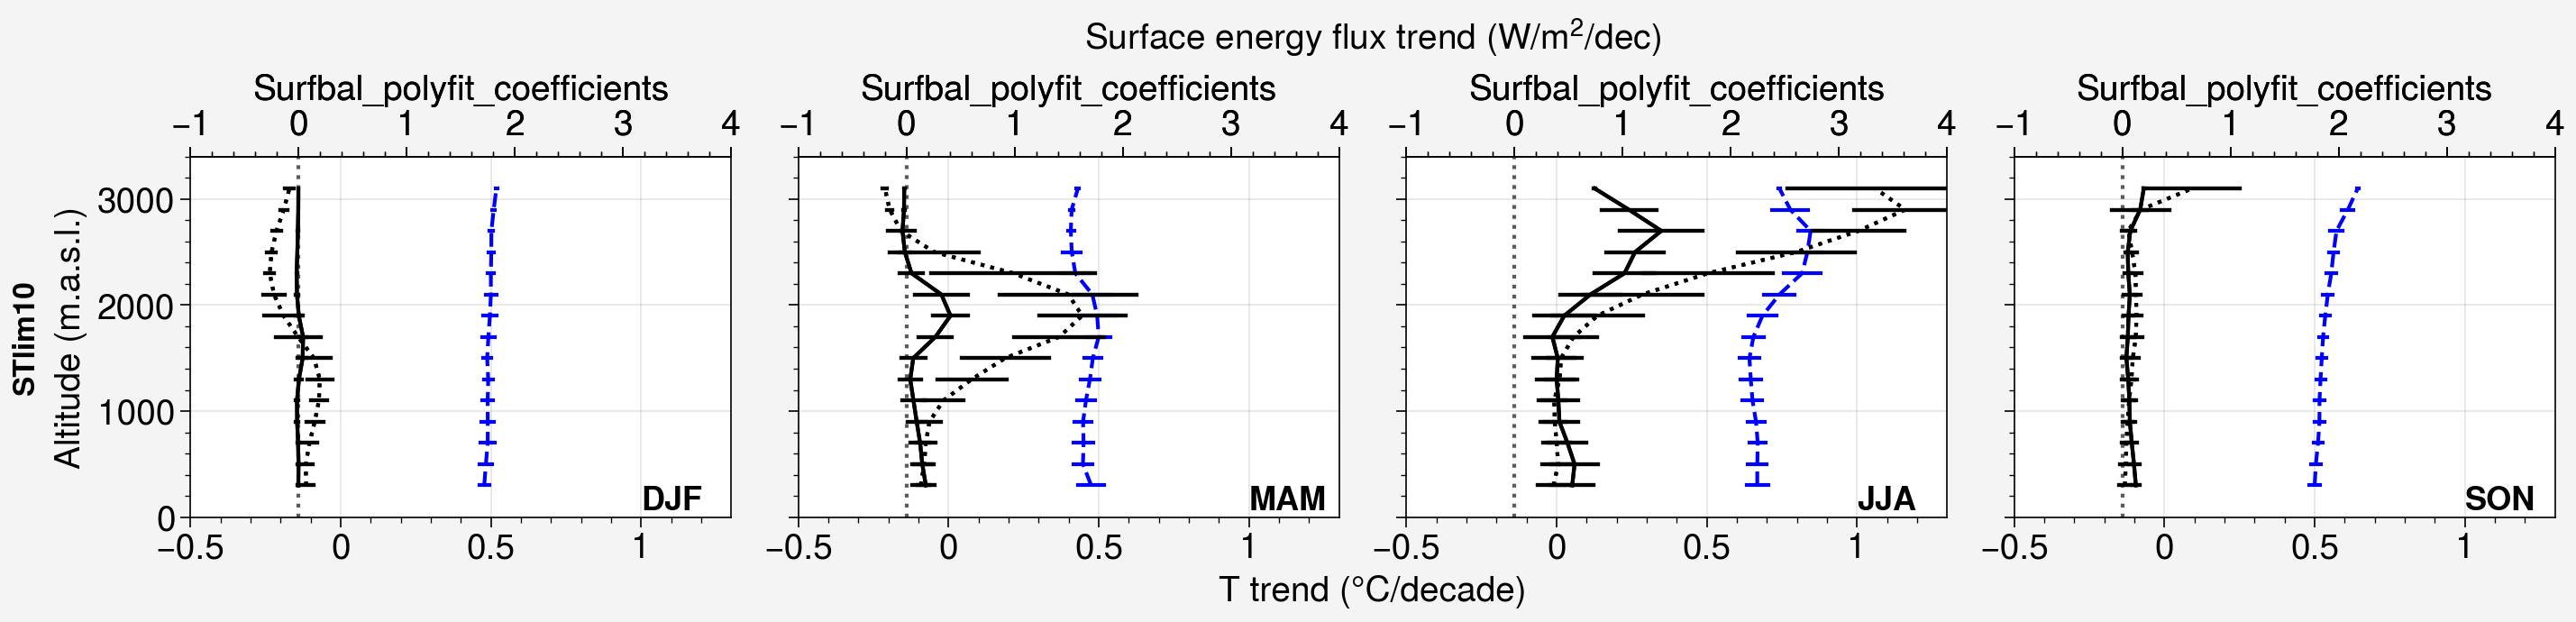

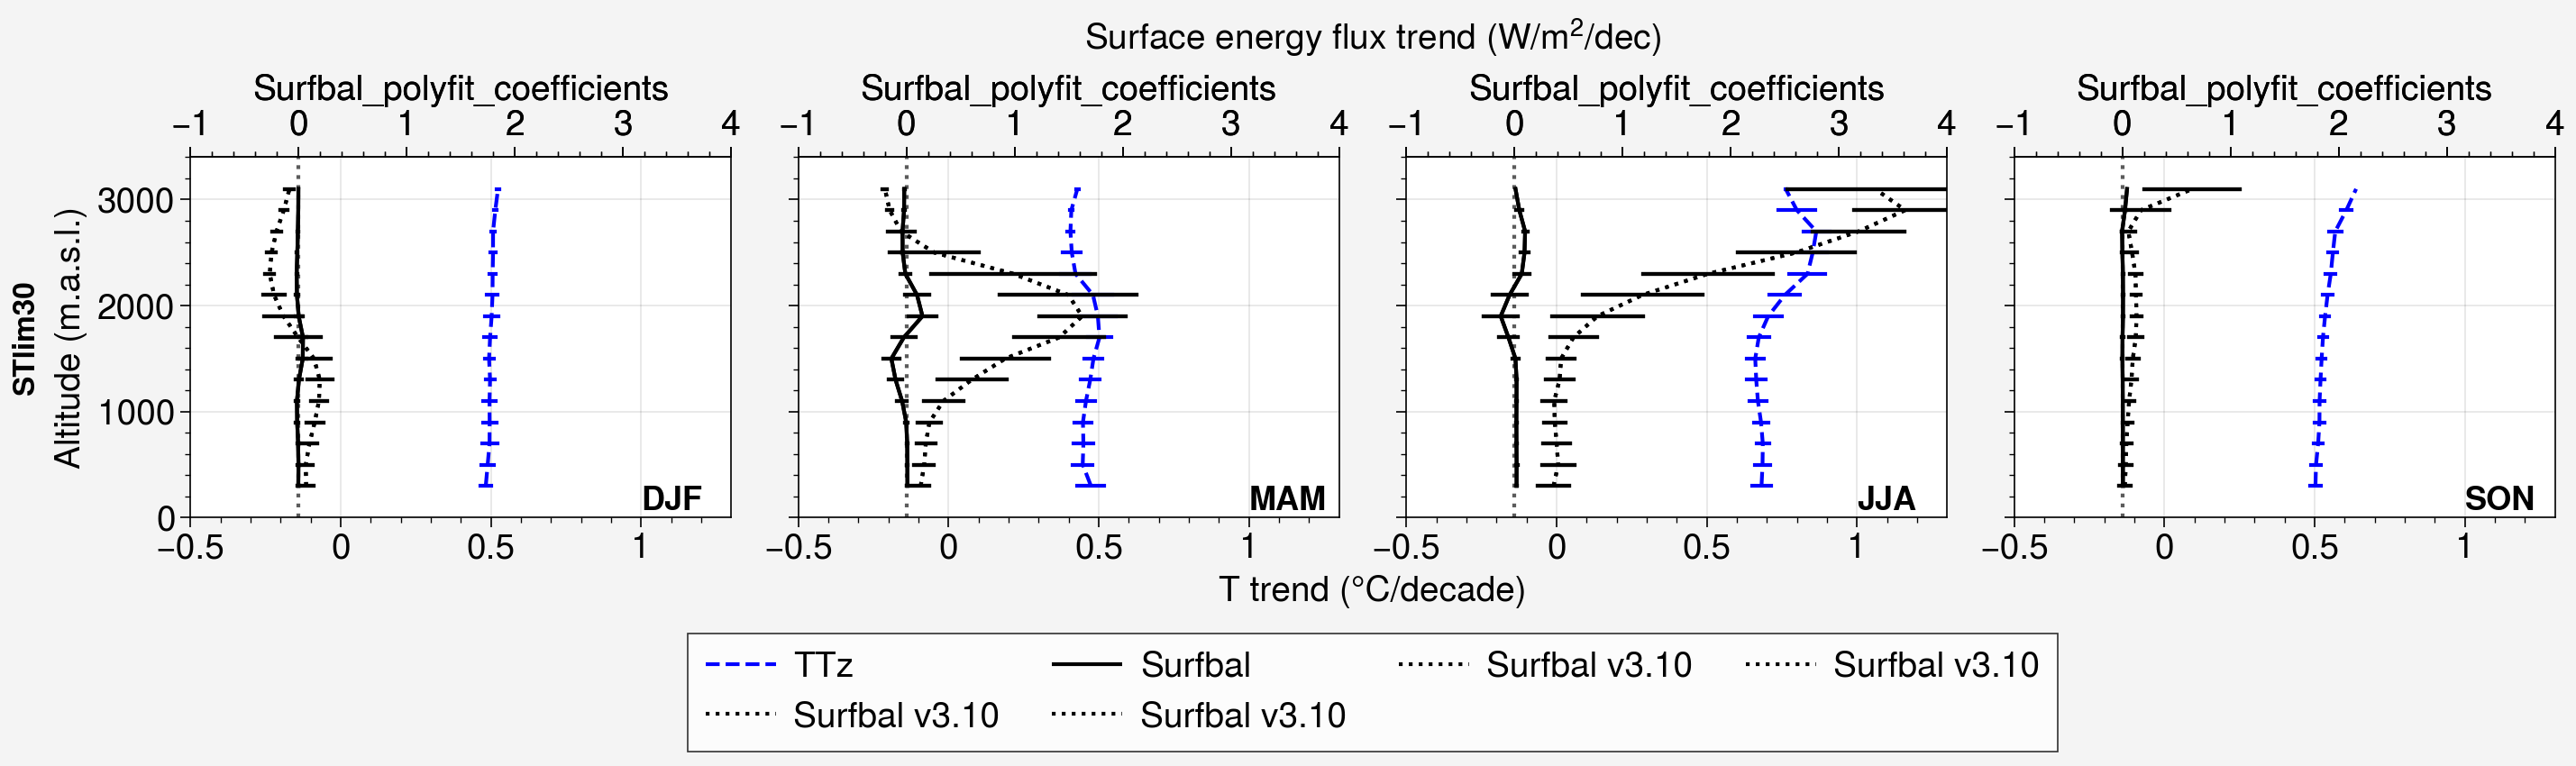

In [33]:
seasons=['DJF','MAM','JJA','SON']
colors = ['b','k']
leg_labels_null = ['','','','','','','','','','','']
leg_labels_full = ['TTz','Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

multiplier = 10 # =10 if trends per decade

# ------------------------ STlim10 simulation ----------------------------

ds_slopes = ds_yrs.polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels_smallish)

ds_slopes2 = ds_yrsv310.isel(y=slice(jmin,jmax),x=slice(imin,imax)).polyfit('Year', deg=1)
ds_slopes_Hlev2, ds_slopes_Hlev_std2 = altitude_lev_slopes(ds_slopes2,levels=levels)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3,axheight=2)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
            ax2.plot(multiplier*ds_slopes_Hlev2[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],linestyle=':',label='Surfbal v3.10')
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
                slope_var = ds_slopes_Hlev2[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std2[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-1,4)


#f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle,rowlabels=['STlim10'])

# -------------------------------- STlim30 simulation --------------------------------------

ds_slopes = ds_yrs2.polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels_smallish)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3,axheight=2)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
            ax2.plot(multiplier*ds_slopes_Hlev2[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],linestyle=':',label='Surfbal v3.10')
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
                slope_var = ds_slopes_Hlev2[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std2[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-1,4)

f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle,rowlabels=['STlim30'])

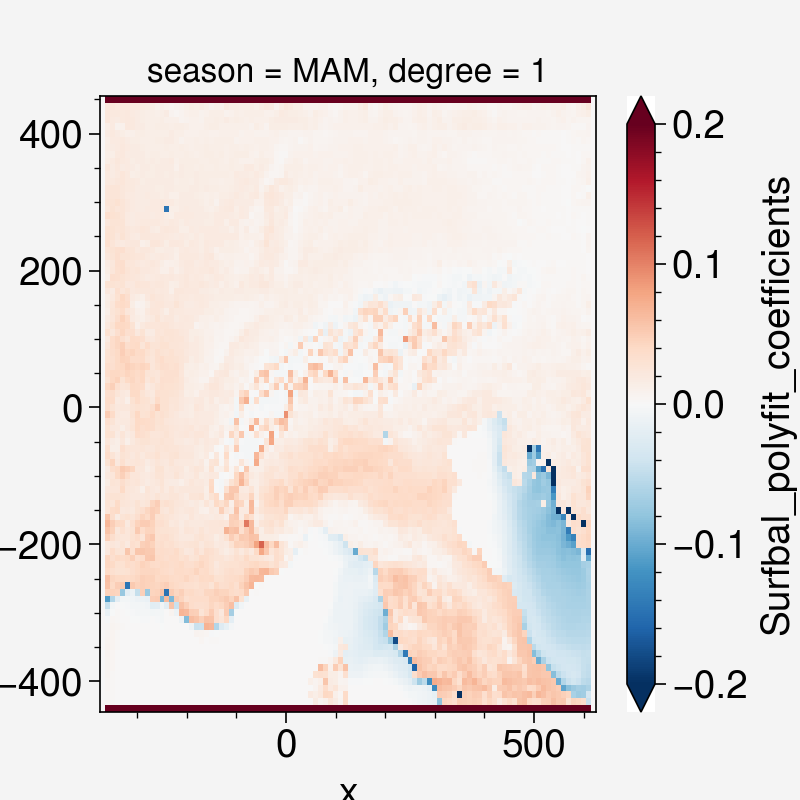

In [27]:
ds_slopes.Surfbal_polyfit_coefficients.sel(season='MAM').sel(degree=1).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

In [ ]:
 iloc1=50, jloc1=50, iloc2=35, jloc2=50

## Monthly trends maps

In [26]:
yrs = range(2015,2101)
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/'

ds_mon_yrly = xr.open_dataset(path+'ds_Jan2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))

ds_mon = xr.open_dataset(path+'ds_Feb2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Mar2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Apr2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_May2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Jun2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Jul2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Aug2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Sep2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Oct2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Nov2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')
ds_mon = xr.open_dataset(path+'ds_Dec2015-2100_surfbal.npy')['Surf_Bal'].assign_coords(time=("time", yrs))
ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon], dim='Month')


ds_mon_yrly = ds_mon_yrly.assign_coords(Month=("Month",range(1,13)))


In [27]:
#ds_mon_yrly = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Jan2015-2100_surfbal.npy')

ds_mon_yrly

<xarray.DataArray 'Surf_Bal' (Month: 12, time: 86, y: 90, x: 100)>
array([[[[ 0.00000000e+00,  3.62307953e+02,  3.61896454e+02, ...,
           3.32917175e+02,  3.33873199e+02,  0.00000000e+00],
         [ 0.00000000e+00,  1.38352022e-01,  2.56131500e-01, ...,
           8.34464133e-02,  2.80504443e+03,  0.00000000e+00],
         [ 0.00000000e+00,  2.19627663e-01,  3.93128544e-01, ...,
           2.14316968e+03,  1.95962134e+03,  0.00000000e+00],
         ...,
         [ 0.00000000e+00, -4.53979708e-03, -5.76248718e-03, ...,
          -3.16660777e-02, -3.54985148e-02,  0.00000000e+00],
         [ 0.00000000e+00, -1.27706500e-02, -1.25970114e-02, ...,
          -1.99901536e-02, -2.94222757e-02,  0.00000000e+00],
         [ 0.00000000e+00,  2.91144348e+02,  2.90879822e+02, ...,
           2.70623108e+02,  2.70797852e+02,  0.00000000e+00]],

        [[ 0.00000000e+00,  3.62783966e+02,  3.62359619e+02, ...,
           3.32731171e+02,  3.33582733e+02,  0.00000000e+00],
         [ 0.00000000e+00,  2.15029910e-01,  3.02408695e-01, ...,
           1.40749728e-02,  1.57654150e+03,  0.00000000e+00],
         [ 0.00000000e+00,  2.70877868e-01,  3.85472298e-01, ...,
           6.43080566e+02,  6.69659180e+02,  0.00000000e+00],
...
          -2.55715828e-02, -2.01557986e-02,  0.00000000e+00],
         [ 0.00000000e+00, -4.32796367e-02, -4.35772054e-02, ...,
          -2.04611551e-02, -2.69505493e-02,  0.00000000e+00],
         [ 0.00000000e+00,  3.29865814e+02,  3.29631134e+02, ...,
           3.09978821e+02,  3.10193634e+02,  0.00000000e+00]],

        [[ 0.00000000e+00,  3.89077454e+02,  3.88855103e+02, ...,
           3.59959381e+02,  3.61089844e+02,  0.00000000e+00],
         [ 0.00000000e+00,  3.02335215e+00,  4.91722971e-01, ...,
          -6.59032091e-02,  1.11340076e+03,  0.00000000e+00],
         [ 0.00000000e+00,  5.80460167e+00,  5.60571909e-01, ...,
           1.22267847e+03,  1.14942932e+03,  0.00000000e+00],
         ...,
         [ 0.00000000e+00, -4.34698611e-02, -3.95070575e-02, ...,
          -6.46688603e-03, -1.29633043e-02,  0.00000000e+00],
         [ 0.00000000e+00, -4.54610586e-02, -4.17276919e-02, ...,
          -9.04528517e-03, -1.82917845e-02,  0.00000000e+00],
         [ 0.00000000e+00,  3.22318329e+02,  3.21982391e+02, ...,
           2.95433380e+02,  2.95684937e+02,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * x        (x) float32 -370.0 -360.0 -350.0 -340.0 ... 590.0 600.0 610.0 620.0
  * y        (y) float32 -440.0 -430.0 -420.0 -410.0 ... 420.0 430.0 440.0 450.0
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * Month    (Month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [28]:
ds_slopes_mon = ds_mon_yrly.polyfit('time', deg=1)
ds_slopes_mon.isel(degree=0)

<xarray.Dataset>
Dimensions:               (Month: 12, y: 90, x: 100)
Coordinates:
  * Month                 (Month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * y                     (y) float32 -440.0 -430.0 -420.0 ... 430.0 440.0 450.0
  * x                     (x) float32 -370.0 -360.0 -350.0 ... 600.0 610.0 620.0
    degree                int64 1
Data variables:
    polyfit_coefficients  (Month, y, x) float64 0.0 0.2941 0.2931 ... 0.3129 0.0

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

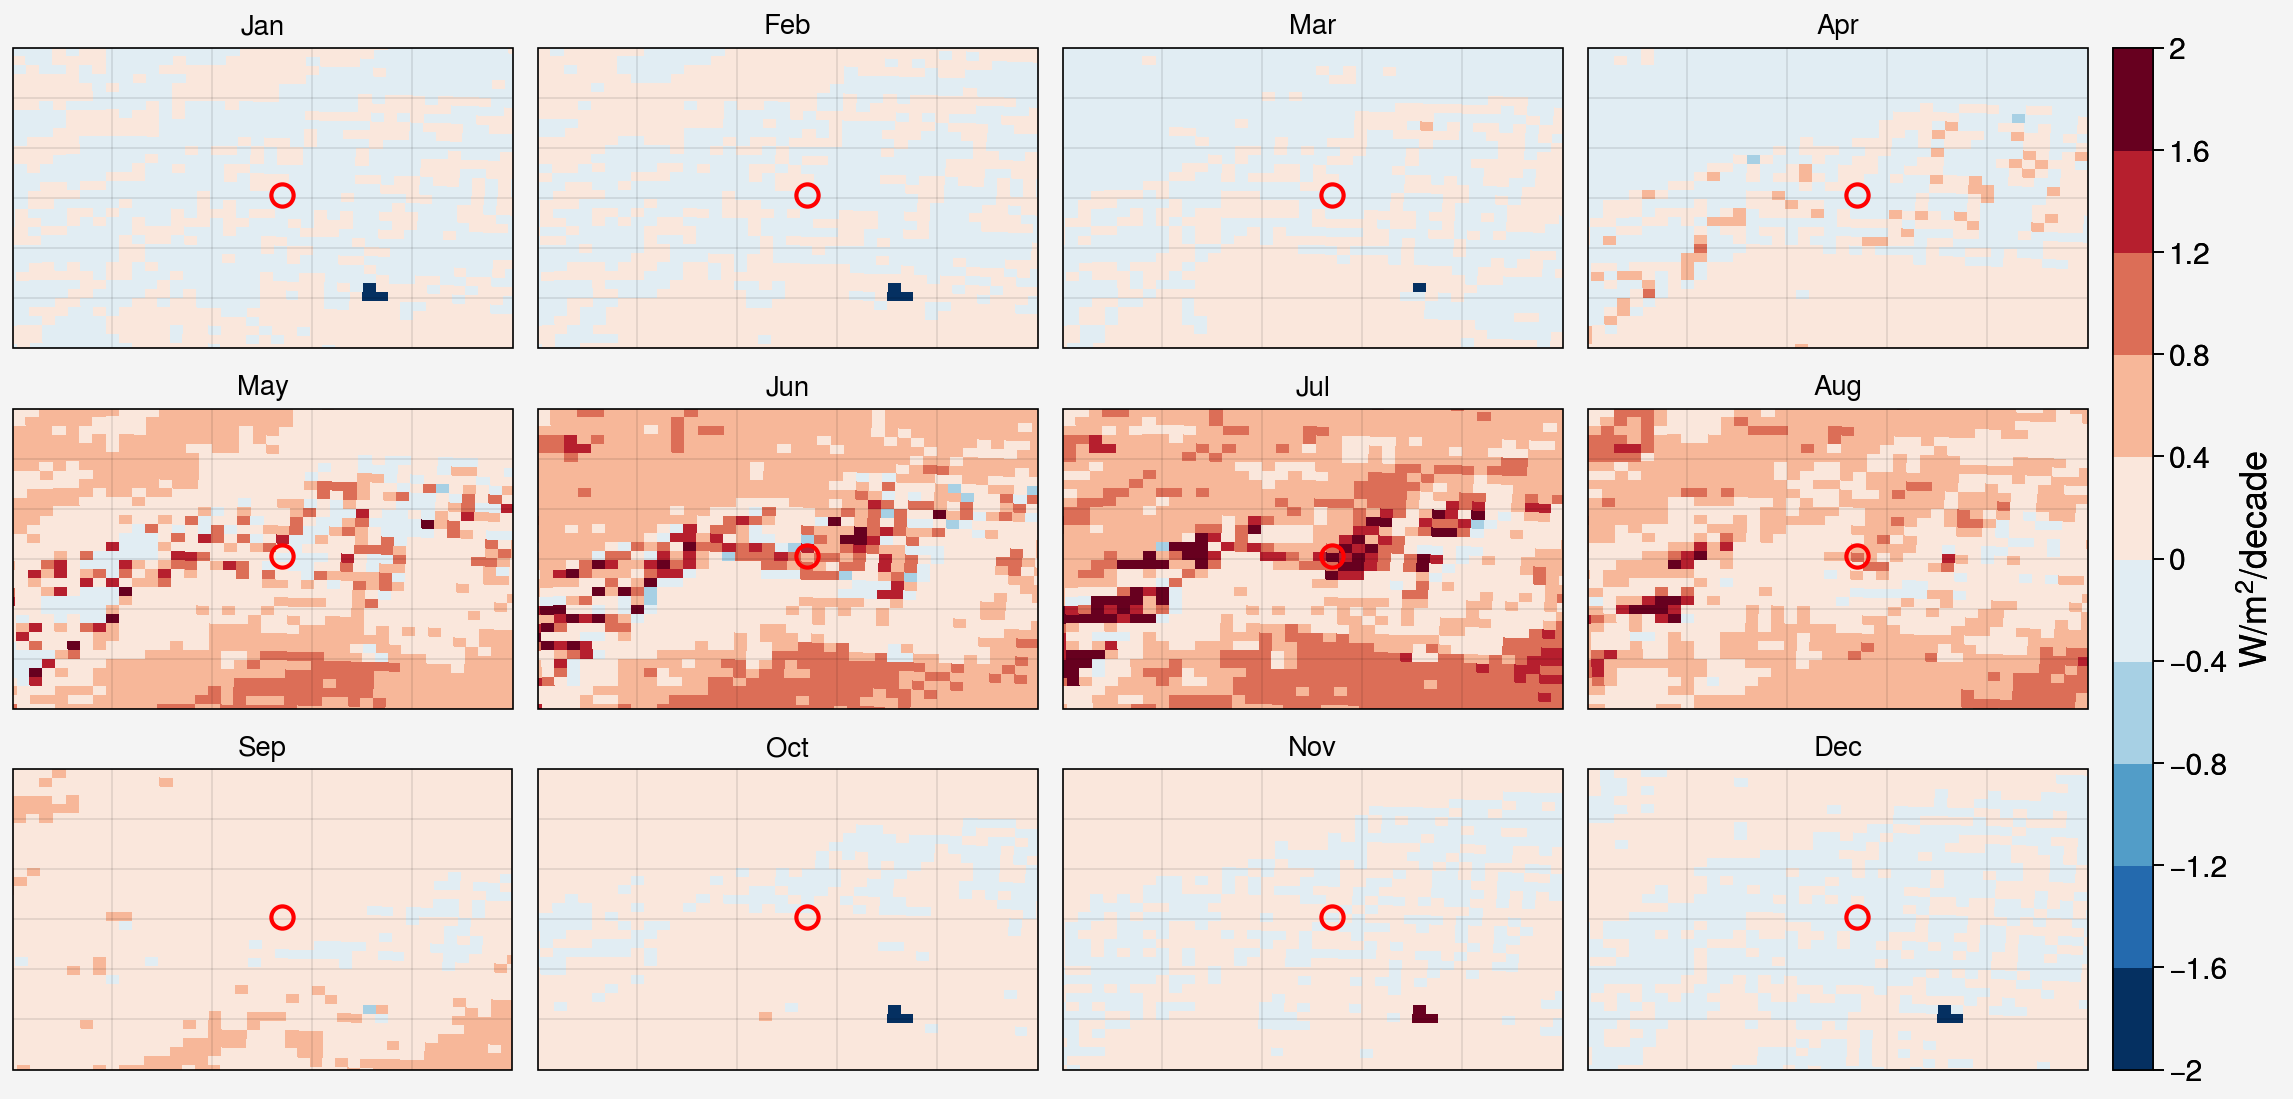

In [38]:
f,axs = pplt.subplots(proj='cyl',ncols=4, nrows=3)

mon_name = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

iloc1=50
jloc1=50
multiplier = 10 # 10 for unit per decade

for mon in range(12):
    ax=axs[mon]
    m=ax.pcolormesh(ds_smallish.LON, ds_smallish.LAT, multiplier*ds_slopes_mon['polyfit_coefficients'].isel(degree=0,Month=mon),levels=np.linspace(-2,2,11),
                    cmap='RdBu_r')
    ax.plot(ds_smallish.LON[iloc1,jloc1], ds_smallish.LAT[iloc1,jloc1],'ro',facecolors='none',markersize=8,markeredgewidth=1.5)
    ax.format(title=mon_name[mon])

f.colorbar(m, label= 'W/$m^2$/decade',labelsize='x-large',ticklabelsize='large')
f.format(latlim=[45.,48.],lonlim=[7.,12.])


In [39]:
ds_slopes_mon['polyfit_coefficients'].isel(degree=0)[:,50,50]

<xarray.DataArray 'polyfit_coefficients' (Month: 12)>
array([-0.00108015, -0.00080477, -0.00121337, -0.00384739, -0.00382334,
        0.07463317,  0.2170046 ,  0.08177582,  0.01319659,  0.00126519,
       -0.00064591, -0.00189254])
Coordinates:
  * Month    (Month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    y        float32 60.0
    x        float32 130.0
    degree   int64 1

/tmp/ipykernel_1252691/1452583210.py:24: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend()


(<matplotlib.legend.Legend at 0x14eb079a8f10>,
 <matplotlib.legend.Legend at 0x14eb0797dc00>)

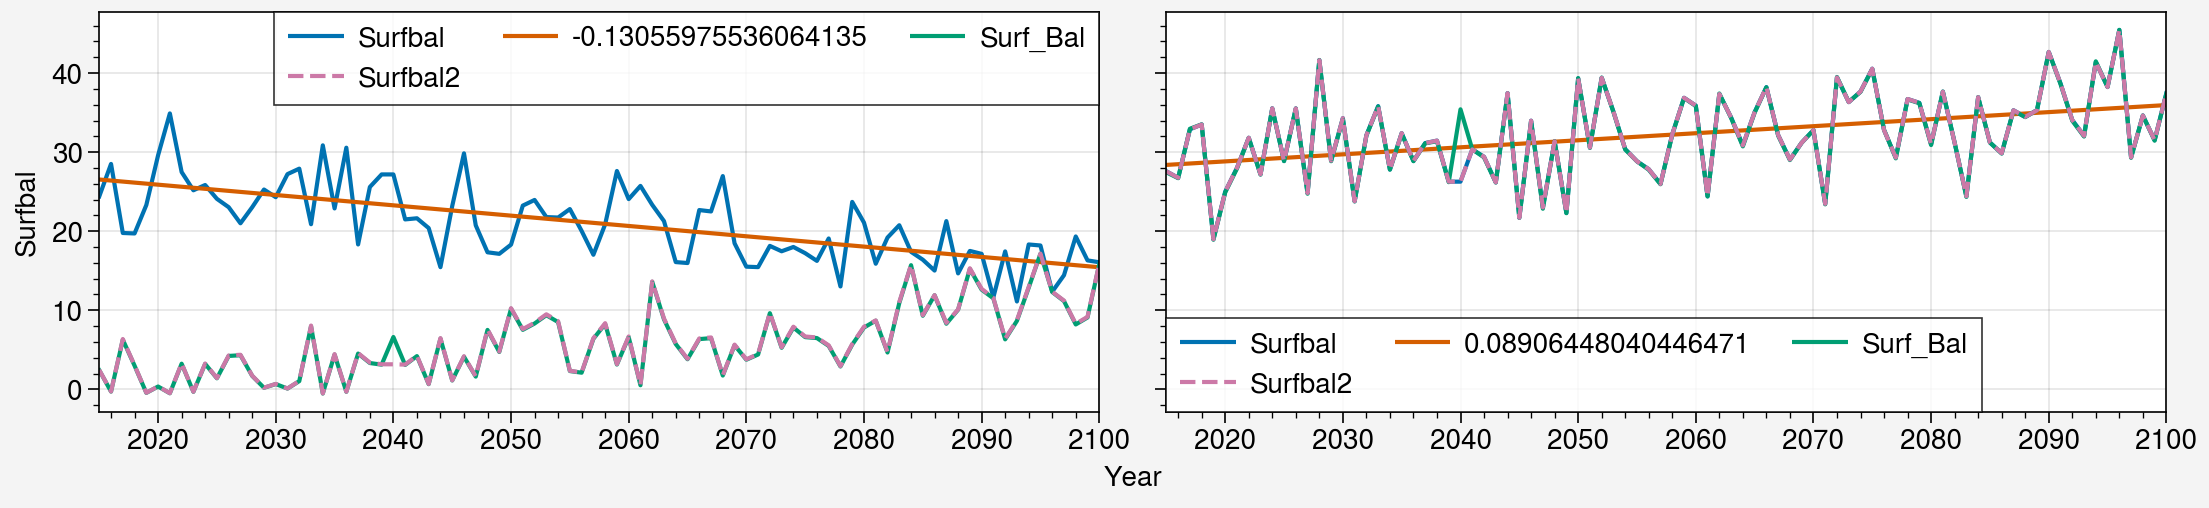

In [30]:
f,axs = pplt.subplots(ncols=2,axwidth=5,axheight=2)

iloc1=50
jloc1=50

ds_mon_JJA = ds_mon_yrly.sel(Month=[6,7,8]).mean(axis=0)

axs[0].plot(ds_yrs.sel(season='JJA').Surfbal[:,iloc1,jloc1])
axs[0].plot(ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,iloc1,jloc1]*ds_yrs.Year+ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[1,iloc1,jloc1],
            label=ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,iloc1,jloc1])
axs[0].plot(ds_mon_JJA[:,iloc1,jloc1])
axs[0].plot(ds_yrs.sel(season='JJA').Surfbal2[:,iloc1,jloc1],'--')


iloc2=35
jloc2=50

axs[1].plot(ds_yrs.sel(season='JJA').Surfbal[:,iloc2,jloc2])
axs[1].plot(ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,iloc2,jloc2]*ds_yrs.Year+ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[1,iloc2,jloc2],
           label=ds_slopes.sel(season='JJA').Surfbal_polyfit_coefficients[0,iloc2,jloc2])
axs[1].plot(ds_mon_JJA[:,iloc2,jloc2])
axs[1].plot(ds_yrs.sel(season='JJA').Surfbal2[:,iloc2,jloc2],'--')

axs.legend()

/tmp/ipykernel_1493530/1361462580.py:26: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend()


(<matplotlib.legend.Legend at 0x14679b0238e0>,
 <matplotlib.legend.Legend at 0x14679ae97e20>)

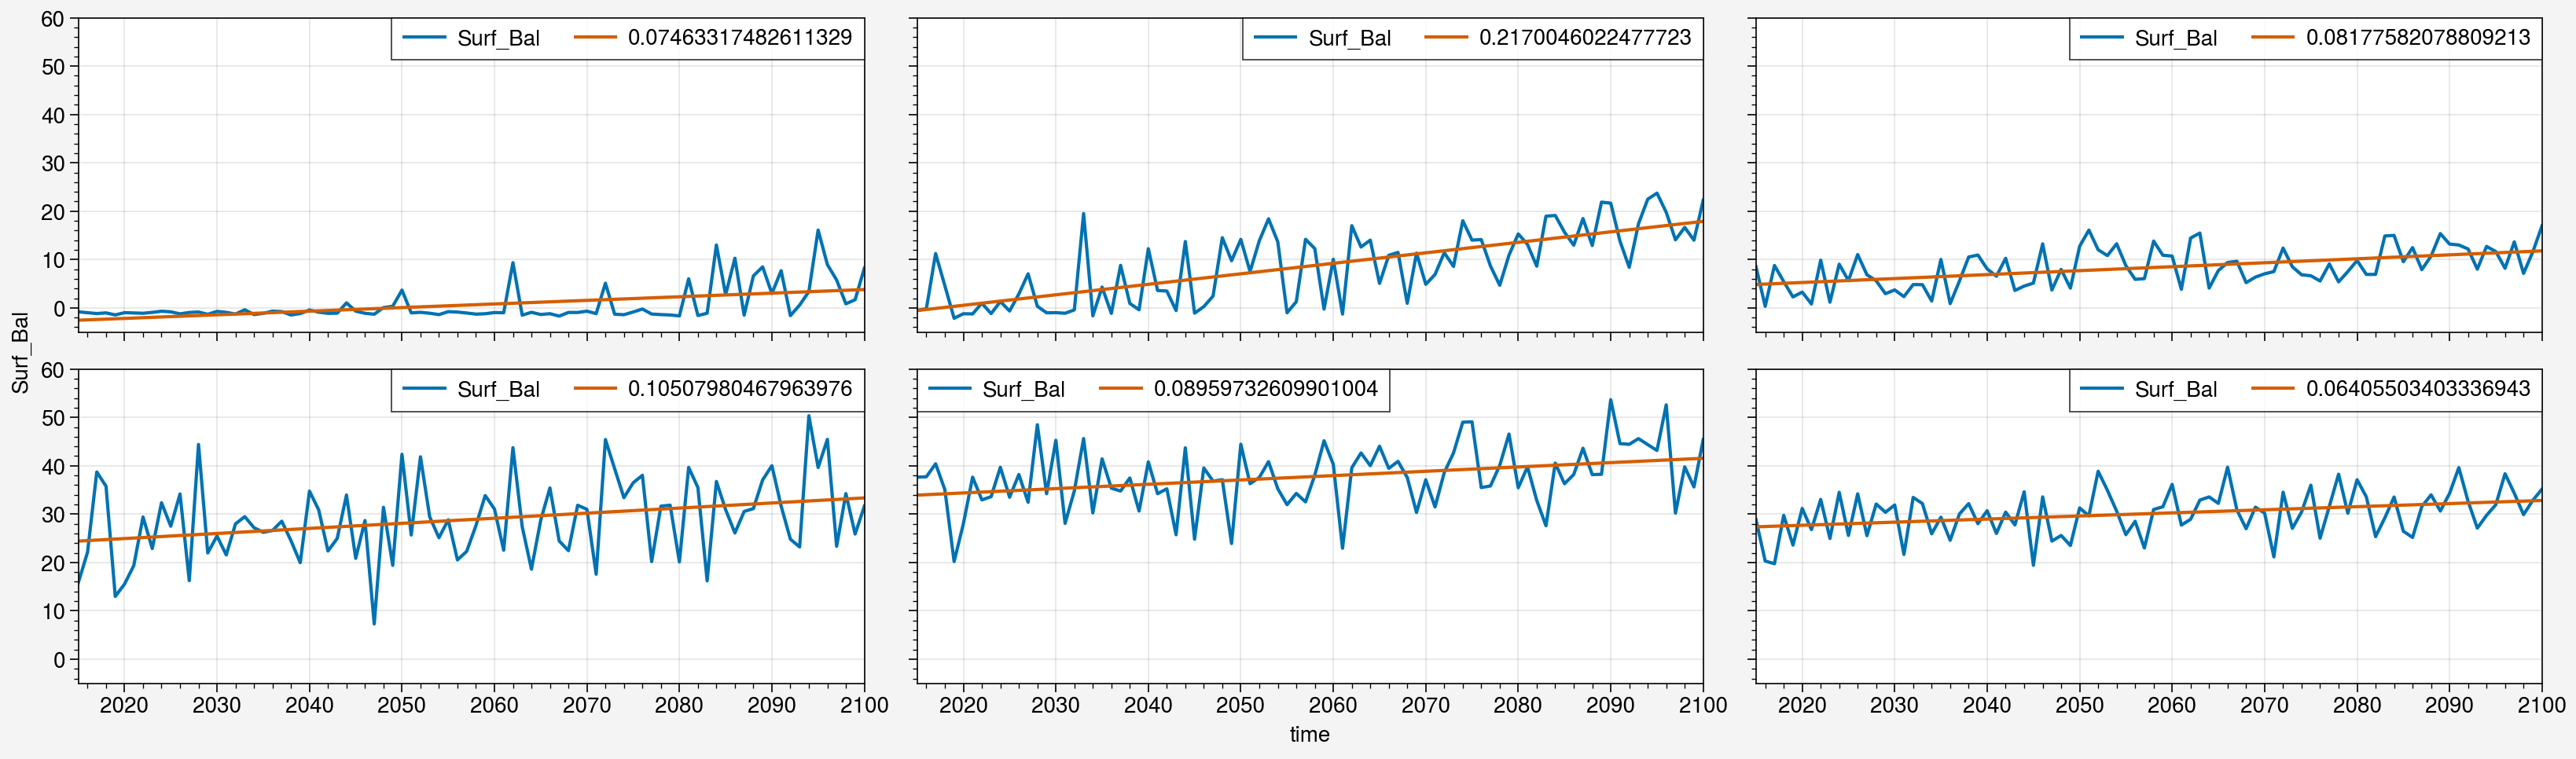

In [58]:
ds_mon_yrly

f,axs = pplt.subplots(ncols=3,nrows=2,axwidth=5,axheight=2)

iloc1=50
jloc1=50

iloc2=35
jloc2=50

ymin = -5
ymax = 60

for m in range(3):
    mon_nr = m + 6
    axs[m].plot(ds_mon_yrly.sel(Month=mon_nr)[:,iloc1,jloc1])
    axs[m].plot(ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[0,iloc1,jloc1]*ds_yrs.Year+ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[1,iloc1,jloc1],
            label=ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[0,iloc1,jloc1])
    axs[m].set_ylim([ymin,ymax])

    axs[m+3].plot(ds_mon_yrly.sel(Month=mon_nr)[:,iloc2,jloc2])
    axs[m+3].plot(ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[0,iloc2,jloc2]*ds_yrs.Year+ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[1,iloc2,jloc2],
            label=ds_slopes_mon.sel(Month=mon_nr).polyfit_coefficients[0,iloc2,jloc2])
    axs[m+3].set_ylim([ymin,ymax])

axs.legend()

In [60]:
ds_mon_yrly.sel(Month=[6,7,8])

<xarray.DataArray 'Surf_Bal' (Month: 3, time: 86, y: 90, x: 100)>
array([[[[ 0.00000000e+00,  6.37500671e+02,  6.36299316e+02, ...,
           6.15381531e+02,  6.15519775e+02,  0.00000000e+00],
         [ 0.00000000e+00, -6.59088418e-02, -5.17532304e-02, ...,
           7.84313126e+01,  9.04120579e-02,  0.00000000e+00],
         [ 0.00000000e+00, -6.19383715e-02, -4.66136895e-02, ...,
           3.59660238e-02,  4.86401096e-02,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  6.40715866e+01,  5.62668419e+01, ...,
           6.16283913e+01,  6.40371780e+01,  0.00000000e+00],
         [ 0.00000000e+00,  6.59852448e+01,  6.53252792e+01, ...,
           6.94993820e+01,  8.01623459e+01,  0.00000000e+00],
         [ 0.00000000e+00,  6.19700806e+02,  6.19755310e+02, ...,
           6.13913208e+02,  6.14180054e+02,  0.00000000e+00]],

        [[ 0.00000000e+00,  6.32622986e+02,  6.31594604e+02, ...,
           6.03069641e+02,  6.03832092e+02,  0.00000000e+00],
         [ 0.00000000e+00,  9.10618007e-02,  1.08109243e-01, ...,
           7.66469345e+01,  2.26290211e-01,  0.00000000e+00],
         [ 0.00000000e+00,  9.19695720e-02,  1.05406463e-01, ...,
           1.68622091e-01,  1.75744146e-01,  0.00000000e+00],
...
           3.41695709e+01,  3.41894531e+01,  0.00000000e+00],
         [ 0.00000000e+00,  3.46505394e+01,  3.43868904e+01, ...,
           3.89923439e+01,  4.28523598e+01,  0.00000000e+00],
         [ 0.00000000e+00,  6.00939392e+02,  6.00895447e+02, ...,
           5.96897949e+02,  5.97225525e+02,  0.00000000e+00]],

        [[ 0.00000000e+00,  6.44261963e+02,  6.42653259e+02, ...,
           6.22414795e+02,  6.22983521e+02,  0.00000000e+00],
         [ 0.00000000e+00,  4.60802019e-01,  5.10081112e-01, ...,
           5.19724426e+01,  1.13270426e+00,  0.00000000e+00],
         [ 0.00000000e+00,  4.54024613e-01,  4.91676539e-01, ...,
           1.20567358e+00,  1.13803363e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  4.03688812e+01,  3.53500290e+01, ...,
           3.85925179e+01,  3.91829834e+01,  0.00000000e+00],
         [ 0.00000000e+00,  4.18508186e+01,  3.98895950e+01, ...,
           4.26337547e+01,  4.68644791e+01,  0.00000000e+00],
         [ 0.00000000e+00,  5.96465820e+02,  5.96714478e+02, ...,
           6.02317810e+02,  6.02814331e+02,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * x        (x) float32 -370.0 -360.0 -350.0 -340.0 ... 590.0 600.0 610.0 620.0
  * y        (y) float32 -440.0 -430.0 -420.0 -410.0 ... 420.0 430.0 440.0 450.0
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * Month    (Month) int64 6 7 8

In [15]:
%%time
# creating seasonal dataarray with all vars
ds_sect = ds_big
Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_timestep = 60*60*24 # 60*60*24 seconds in a day

#path = '/bettik/castelli/data/MAR-MPI-ESM/v3.14/STlim30/SSP585/'
path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/'
simcode = 'y'

ds_yrs = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWD.2015.nc')#.resample(time='D').mean()

ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWU.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(LWU = ds_var['LWU'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWD.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SWD = ds_var['SWD'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWU.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SWU = ds_var['SWU'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SHF.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SHF = ds_var['SHF'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LHF.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(LHF = ds_var['LHF'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.GF.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(GF = ds_var['GF'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.HAcc.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(HAcc = ds_var['HAcc'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.SWt.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(SWt = ds_var['SWt'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTz.2015.nc').resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTz = ds_var['TTz'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.MB.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(MB = ds_var['MB'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmin.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTmin = ds_var['TTmin'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmax.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTmax = ds_var['TTmax'])

CPU times: user 1.03 s, sys: 495 ms, total: 1.52 s
Wall time: 3.47 s


In [16]:
%%time

ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EU'+simcode+'.MBm.2015.nc')#.resample(time='D').sum()

ds_var

CPU times: user 15.9 ms, sys: 10 ms, total: 25.9 ms
Wall time: 197 ms


<xarray.Dataset>
Dimensions:  (time: 365, sector: 3, y: 126, x: 201)
Coordinates:
  * sector   (sector) float32 1.0 2.0 3.0
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
Data variables:
    MBm      (time, sector, y, x) float32 ...
Attributes:
    title:        ICE - Exp: y56 - 20150101
    institution:  ULg (Xavier Fettweis)
    history:      Tue May  7 11:45:03 2024: ncks -v MBm /bettik/castelli/data...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

In [17]:
%%time

FRV_sect1 = np.array(ds_sect.FRV.sel(sector=1.0)/100)
FRV_sect2 = np.array(ds_sect.FRV.sel(sector=2.0)/100)
FRV_sect3 = np.array(ds_sect.FRV.sel(sector=3.0)/100)

ds_var.MBm.sel(sector=1.0)*FRV_sect1

CPU times: user 65.6 ms, sys: 153 ms, total: 219 ms
Wall time: 1.62 s


<xarray.DataArray 'MBm' (time: 365, y: 126, x: 201)>
array([[[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
...
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]], dtype=float32)
Coordinates:
    sector   float32 1.0
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0

In [ ]:
melt_MBm_top = ds_var.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                ds_var.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
ds_day_melt_top = melt_MBm_top * Lf / t_timestep
ds_yrs = ds_yrs.assign(melt = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface

In [11]:
%%time

ds_sect = ds_smallish


ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/SSP585/ICE.MPI-ESM_SSP585.EUm.MBmTop.2015.nc').resample(time='D').sum()
melt_MBm_top = ds_var.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                ds_var.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100

CPU times: user 1.4 s, sys: 290 ms, total: 1.69 s
Wall time: 2.1 s


In [12]:
ds_sect.FRV.sel(sector=1.0)

<xarray.DataArray 'FRV' (y: 90, x: 100)>
[9000 values with dtype=float32]
Coordinates:
    sector   float32 1.0
  * x        (x) float32 -370.0 -360.0 -350.0 -340.0 ... 590.0 600.0 610.0 620.0
  * y        (y) float32 -440.0 -430.0 -420.0 -410.0 ... 420.0 430.0 440.0 450.0
Attributes:
    units:          %
    long_name:      Vegetation Class Coverage
    standard_name:  Vegetation_Class_Coverage
    actual_range:   [  0. 100.]

In [10]:
ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/SSP585/ICE.MPI-ESM_SSP585.EUm.MBmTop.2015.nc').resample(time='D').sum()

ds_var

<xarray.Dataset>
Dimensions:  (time: 365, sector: 3, y: 90, x: 100)
Coordinates:
  * sector   (sector) float32 1.0 2.0 3.0
  * x        (x) float32 -370.0 -360.0 -350.0 -340.0 ... 590.0 600.0 610.0 620.0
  * y        (y) float32 -440.0 -430.0 -420.0 -410.0 ... 420.0 430.0 440.0 450.0
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    MBmTop   (time, sector, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:        ICE - Exp: m02 - 20150101
    institution:  ULg (Xavier Fettweis)
    history:      Mon Jul  7 17:42:22 2025: ncks -v MBmTop /bettik/castelli/M...
    netcdf:       4.8.0 of May  2 2023 12:43:48 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...